In [27]:
Full={}
Full_f={}



In [28]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
import matplotlib.pyplot as plt
import os,sys
import glob
import numpy as np
import scipy
from scipy import interpolate


def Cross_table(tgt,table):
   
    #Fill the table once
    if len(table) != 10:
        for i in range(16):
            file_name = "/home/jbane/tritium/T2_externals/OUT/marathon_kin{}_{}.out".format(i,tgt)
           # print(file_name)
            if os.path.isfile(file_name):
                table[i] = pd.read_table(file_name,delim_whitespace=True)
                
                
def interper(DFs,x,Q):
    f = interpolate.interp2d(DFs["x"],DFs["Q2"],DFs["Sig_Born"],kind='linear', copy=True,  bounds_error=True)
    sigma_born=f(x,Q)
    h = interpolate.interp2d(DFs["x"],DFs["Q2"],DFs["Sig_Rad"],kind='linear', copy=True, bounds_error=True )
    sigma_rad=h(x,Q)
    return sigma_born,sigma_rad  

def weighted_average(df,data_col,weight_col,by_col):
    df['_data_times_weight'] = df[data_col]*df[weight_col]
    df['_weight_where_notnull'] = df[weight_col]*pd.notnull(df[data_col])
    g = df.groupby(by_col)
    result = g['_data_times_weight'].sum() / g['_weight_where_notnull'].sum()
    del df['_data_times_weight'], df['_weight_where_notnull']
    return result


In [149]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
import matplotlib.pyplot as plt
import os,sys
import glob
import numpy as np


def all_tgt(tgt,bins):


    table={}

    Cross_table(tgt,table)



    Xaxis="Xbj" #theta / Xbj
    if Xaxis == "Xbj":
        xaxis="xbj"
    else :
        xaxis="theta"

    mcfile='/home/jbane/tritium/Tri_offline/MC_comparison/yield_output/{}bins/{}/'.format(bins,xaxis)
    datafile='/home/jbane/tritium/Tri_offline/yield/yield_output/{}bins/{}/'.format(bins,xaxis)
    kins={}
    kin={}
    sig_r={}
    sig_b={}
    sig_rr={}
    sig_bb={}

    kins=sorted(glob.glob('{}{}*.dat'.format(mcfile,tgt)))

    kin_num_array={}

    mcDF={}
    dataDF={}
    mcDFs={}
    dataDFs={}
    ratios={}
    i=0
    for i in range(len(kins)):
        kin[i] = kins[i].replace(mcfile,"")
        kin[i] = kin[i].replace('.dat',"")

        kin_str_num=kin[i].replace("{}_kin".format(tgt),"")
        kin_num=int(kin_str_num)   
        kin_num_array[i]=kin_num

       # if kin[i]== 'D2_kin3':
       #     break
        #print(kin[i])
        mcfileR=mcfile+'{}.dat'.format(kin[i])
        datafileR=datafile+'{}.dat'.format(kin[i])
        #print(datafileR)
        #print(mcfileR)
        chk1=0
        chk=0
        if os.path.isfile(mcfileR):
            chk=1
        else:
            ("MC file does not exist") 
            chk=0
        if os.path.isfile(datafileR):
            chk1=1
        else :
            print("Data file does not exist")
            chk1=0
        if chk==0 or chk1==0:
            mcDF[i]=pd.DataFrame()
            dataDF[i]=pd.DataFrame()
            continue     
        #print(kin[i])

        mcDF[i]=pd.read_table(mcfileR,delim_whitespace=True)
        dataDF[i]=pd.read_table(datafileR,delim_whitespace=True)
        mcDF[i]['yield']=mcDF[i]['Yield']/1000.0
        mcDF[i]['Error']=mcDF[i]['Error']/1000.0

        dataDF[i]['yield']=dataDF[i]['Yield']
        mcmed=mcDF[i]['yield'].mean()
        datamed=dataDF[i]['yield'].mean()
        mcDFs[i]=mcDF[i][mcDF[i]['yield'] >=mcmed *0.5]
        dataDFs[i]=dataDF[i][dataDF[i]['yield'] >= datamed *0.5]
        mcDFs[i]=mcDFs[i].dropna()
        dataDFs[i]=dataDFs[i].dropna()
        #drop the first 2 and last 2 bins

        #dataDFs[i]=dataDFs[i].drop(dataDFs[i].index[0])
        #dataDFs[i]=dataDFs[i].drop(dataDFs[i].index[0])
        dl=len(dataDFs[i])
        #dataDFs[i]=dataDFs[i].drop(dataDFs[i].index[dl-1])
        #dataDFs[i]=dataDFs[i].drop(dataDFs[i].index[dl-2])    

      #  mcDFs[i]=mcDFs[i].drop(mcDFs[i].index[0])
      #  mcDFs[i]=mcDFs[i].drop(mcDFs[i].index[0])
        ml=len(dataDFs[i])


     #   mcDFs[i]=mcDFs[i].drop(mcDFs[i].index[ml-1])
      #  mcDFs[i]=mcDFs[i].drop(mcDFs[i].index[ml-2])



        if len(dataDFs[i]) <2 :
                continue

                    #cut out the edge bins for now
        dataDFs[i]=dataDFs[i].drop(dataDFs[i].index[0])
        #dataDFs[i]=dataDFs[i].drop(dataDFs[i].index[0])
        last= len(dataDFs[i].index)
        dataDFs[i]=dataDFs[i].drop(dataDFs[i].index[last-1])
        #dataDFs[i]=dataDFs[i].drop(dataDFs[i].index[last-2])
        mcDFs[i]=mcDFs[i].drop(mcDFs[i].index[0])
        ml=len(mcDFs[i].index)
        #print ("                          ", ml                  )

        mcDFs[i]=mcDFs[i].drop(mcDFs[i].index[ml-1])

        minind= dataDFs[i].index[0]
        maxind=dataDFs[i].index[len(dataDFs[i].index)-1]

        mcDFs[i]=mcDFs[i][mcDFs[i].index>=minind]
       # mcDFs[i]=mcDFs[i][mcDFs[i].index<=maxind]        


       # print("data",i, dataDFs[i])
       # print("MC  ",i,mcDFs[i])
        #dataDFs[i]= dataDFs[i].drop(dataDFs[i].index[[0,len(dataDFs[i])-1]])
        #mcDFs[i]=     mcDFs[i].drop(mcDFs[i].index[  [0,  len(mcDFs[i])-1]])
        dataDFs[i]['Stat_err']=1.0/np.sqrt((dataDFs[i]['Ne']))*dataDFs[i]['yield']*10
        ratios[i] = mcDFs[i].copy()
        ratios[i].rename(columns={'Ne':'MC_Ne'})
        ratios[i]['Data_Ne']=dataDFs[i]['Ne']
        #ratios[i].drop('yield')
        ratios[i]["data_err"]=dataDFs[i]['Error']
        ratios[i]['data_Y'] =dataDFs[i]['yield']
        ratios[i]['MC_Y'] = mcDFs[i]['yield']
        ratios[i]['ratio'] = dataDFs[i]['yield']/mcDFs[i]['yield']
        ratios[i]['offset'] = dataDFs[i]['yield'] - mcDFs[i]['yield']
        ratios[i]['ratio_err'] =ratios[i]['ratio']*np.sqrt( pow((1/(np.sqrt(dataDFs[i]['Ne']))),2)  +   pow((1/(np.sqrt(mcDFs[i]['Ne']))),2)     )

        i=i+1

    import matplotlib._color_data as mcd
    overlap = [name for name in mcd.CSS4_COLORS if "xkcd:" + name in mcd.XKCD_COLORS]

    markers =[[3,0,0]  ,[5,1,90] ,[4,0,90],[3,1,90],[6,2,0] ,[5,0,0] ,[4,1,0],[7,0,0]]
    markers2 =[[3,0,0] ,[5,1,90] ,[4,0,90],[3,1,90],[6,2,0] ,[5,0,0],[4,1,0],[7,0,0]]
    colors=['red', 'Green', 'Blue', 'Orange', 'Purple', 'Cyan', 'Magenta','Teal','Brown','Maroon','Mint','Navy']#, f032e6, bcf60c, fabebe, 008080, e6beff, 9A6324, fffac8, 800000, aaffc3, 808000, ffd8b1, 000075, a9a9a9, ffffff, 000000]
    fig= plt.figure(dpi=500,figsize=(9,5))
    ax=fig.add_subplot(2,1,1)
    plt.title('{} Data to MC comparison'.format(tgt))
    bx=fig.add_subplot(2,1,2, sharex=ax)

    #fig,bx=plt.subplots(dpi=250)
    k=int(0)

    print("start second loop")
    for j in range(len(mcDF)):
        xkcd = mcd.XKCD_COLORS["xkcd:" + overlap[j]].upper()
        xkcd2 = mcd.XKCD_COLORS["xkcd:" + overlap[j+len(mcDF)]].upper()
        #print(j , kin[j])
        #print()
        if k == 7:
            k = 0
        if dataDF[j].empty or mcDF[j].empty:
            continue
        if(len(dataDFs[j])) == 0:
            continue
        if(len(mcDF[j])) ==0:
            continue



        kin_str_num=kin[j].replace("{}_kin".format(tgt),"")
        kin_num=int(kin_str_num)
        print(kin_num)

        xbj=ratios[j]["Xbj"]
        Q2=ratios[j]["Q2"]
     #   print( xbj,Q2)
        sig_bb[kin_num],sig_rr[kin_num] =interper(table[kin_num],xbj,Q2)
        print()
        print(sig_bb[kin_num])
        print()
        if len(sig_bb[kin_num]) > 1:
            sig_b[kin_num]=sig_bb[kin_num].diagonal()
        else:
            sig_b[kin_num]=sig_bb[kin_num]
        if len(sig_rr[kin_num]) > 1:
            sig_r[kin_num]=sig_rr[kin_num].diagonal()
        else:
            sig_r[kin_num]=sig_rr[kin_num]
        ratios[j]["Sigma_Born"]=sig_b[kin_num]
        ratios[j]["Sigma_Rad"]=sig_r[kin_num]
        ratios[j]["Sigma_Born_C"]=ratios[j]["Sigma_Born"]*ratios[j]["ratio"]
        ratios[j]["Sigma_Rad_C"]=ratios[j]["Sigma_Rad"]*ratios[j]["ratio"]
        ratios[j]["Sig_Born_err"]=ratios[j]["Sigma_Born"]* np.sqrt( pow( (ratios[j]['ratio_err']/ratios[j]["ratio"] ),2) )
        ratios[j]["Sig_Rad_err"]=ratios[j]["Sigma_Rad"]  * np.sqrt( pow( (ratios[j]['ratio_err']/ratios[j]["ratio"] ),2) )




     #   print(sig_b[kin_num])
     #   print(sig_r[kin_num])    
        #if j == 110:
         #   ax = mcDFs[j].plot(x='theta',y='yield',yerr=':error',kind='scatter', marker=markers[j], color='blue', label='MC run{}'.format(runs[j]))
        #else :

        mcDFs[j].plot(ax=ax,x='{}'.format(Xaxis),y='yield',yerr='Error',kind='scatter',marker=markers[k], color='blue', label='MC {}'.format(kin[j]))

        dataDFs[j].plot(ax=ax,x='{}'.format(Xaxis),y='yield',yerr='Stat_err',kind='scatter', marker=markers2[k], color='red', label='data {}'.format(kin[j]))
        ratios[j].plot(ax=bx,x='{}'.format(Xaxis) ,y='ratio',yerr='ratio_err', xerr='offset', kind='scatter', label='{}'.format(kin[j]),marker=markers2[k] )
        k=k+1
        print(j , kin[j])    



    ax.set_yscale("log")
    ax.grid(True)
    bx.grid(True)
    ax.legend(ncol=4)
    ax.get_legend().remove()
    bx.legend(ncol=5)
    bx.set_ylim(0.9,1.1)

    fig.subplots_adjust(hspace=0)
    fig.savefig('images/{}bins/{}_all.png'.format(bins,tgt))

  
    return ratios

    
def together(tgt,ratios,bins):

    if tgt == "D2" and bins != 50:
        ratio_a=[ratios[0],ratios[5],ratios[6],ratios[7],ratios[8],ratios[9],ratios[10],ratios[1],ratios[2],ratios[3]]
    else:
        ratio_a=[ratios[0],ratios[4],ratios[5],ratios[6],ratios[7],ratios[8],ratios[9],ratios[1],ratios[2],ratios[3]]

    #ratio_a=[ratios[0],ratios[5],ratios[6],ratios[7],ratios[8],ratios[9],ratios[10],ratios[1],ratios[2],ratios[3]]
    if tgt =="D2":
        sel=0
    elif tgt =="He3":
        sel=1
    elif tgt =="H3":
        sel=2
    Full_f[sel] = pd.concat(ratio_a)
    
    
    #Full[sel]=weighted_average(Full_f[sel],
    Full[sel]=Full_f[sel].groupby(level=0).first()

    fig1= plt.figure(dpi=500,figsize=(9,5))
    cx=fig1.add_subplot(1,1,1)
    plt.title('{} Coss Section by Monte Carlo Ratio'.format(tgt))
    Full[sel].plot(ax=cx,x="Xbj",y="Sigma_Born_C",yerr='Sig_Born_err',kind="scatter")
    cx.set_yscale("log")
    plt.ylabel('$\sigma $ ')
    cx.grid(True)

    #fig1.subplots_adjust(hspace=0)
    fig1.savefig('images/{}bins/{}_final.png'.format(bins,tgt),bbox_inches='tight')
    return Full[sel]


def all_plots(Full,bins):
    D2=Full[0]
    He3=Full[1]
    H3=Full[2]

    fig3= plt.figure(dpi=400,figsize=(11,5))
    cx=fig3.add_subplot(1,1,1)
    plt.title('Coss Section by Monte Carlo Ratio')
    D2.plot(ax=cx,x="Xbj",y="Sigma_Born_C",yerr='Sig_Born_err',kind="scatter",label="D2")
    He3.plot(ax=cx,x="Xbj",y="Sigma_Born_C",yerr='Sig_Born_err',kind="scatter",color='r',marker='+',label="He3")
    H3.plot(ax=cx,x="Xbj",y="Sigma_Born_C",yerr='Sig_Born_err',kind="scatter",color='g',marker="x",label="H3")
    cx.set_yscale("log")
    plt.ylabel('$\sigma $ ')
    cx.grid(True)

    #fig1.subplots_adjust(hspace=0)
    fig3.savefig('images/{}bins/all_final.png'.format(bins),bbox_inches='tight')
    return D2, He3, H3

def EMC(D2,He3,H3,bins):

    H3_s=H3[['Xbj','Sigma_Born_C','Sig_Born_err']]
    He3_s=He3[['Xbj','Sigma_Born_C','Sig_Born_err']]
    D2_s=D2[['Xbj','Sigma_Born_C','Sig_Born_err']]
    D2_s=D2_s.rename(columns={"Xbj":"D2_Xbj","Sigma_Born_C": "D2_Born", "Sig_Born_err": "D2_err"})

    EMC_H3  = pd.concat([D2_s,H3_s], axis=1)
    EMC_He3 = pd.concat([D2_s,He3_s],axis=1)

    EMC_H3 =EMC_H3.dropna()
    EMC_He3=EMC_He3.dropna()

    EMC_H3['EMC']  = ( EMC_H3['Sigma_Born_C']/ EMC_H3['D2_Born']) * (2/3) 
    EMC_H3['offset'] = abs(EMC_H3['Xbj'] - EMC_H3['D2_Xbj'])
    EMC_H3['EMC_err'] = EMC_H3['EMC'] * np.sqrt( pow( (EMC_H3['Sig_Born_err']/EMC_H3['Sigma_Born_C']),2) + pow( (EMC_H3['D2_err']/EMC_H3['D2_Born']),2) )

    EMC_He3['EMC'] = (EMC_He3['Sigma_Born_C']/EMC_He3['D2_Born']) * (2/3)
    EMC_He3['offset'] = abs(EMC_He3['Xbj'] - EMC_He3['D2_Xbj'])
    EMC_He3['EMC_err'] = EMC_He3['EMC'] * np.sqrt( pow( (EMC_He3['Sig_Born_err']/EMC_He3['Sigma_Born_C']),2) + pow( (EMC_He3['D2_err']/EMC_He3['D2_Born']),2) )

    fig4= plt.figure(dpi=500,figsize=(11,5))
    dx=fig4.add_subplot(1,1,1)
    plt.title('Cross section ratio ')

    EMC_He3.plot(ax=dx,x="Xbj",xerr='offset',y="EMC",yerr='EMC_err',kind="scatter",color='r',marker='+',label="He3/D")
    EMC_H3.plot( ax=dx,x="Xbj",xerr='offset',y="EMC",yerr='EMC_err',kind="scatter",color='g',marker="x",label="H3/D ")
    
    
    #Add in He3 datamined data
    He3df_un_mined = pd.read_csv("/home/jbane/Downloads/uncorrected.csv",names=['xbj','EMC'])
    He3df_un_mined.plot(ax=dx,x='xbj',y='EMC',color='b',marker='D',label="He3/D E3103")
    
    
    #dx.set_yscale("log")
    dx.set_ylim(0.75,1.2)
    plt.ylabel('($\sigma_A /3)  / (\sigma_D /2) $ ')
    dx.grid(True)

    #fig1.subplots_adjust(hspace=0)
    fig4.savefig('images/{}bins/EMC_final.png'.format(bins),bbox_inches='tight')

    
def ISO_EMC(D2,He3,H3,bins):  
    H3_s=H3[['Xbj','Sigma_Born_C','Sig_Born_err']]
    He3_s=He3[['Xbj','Sigma_Born_C','Sig_Born_err']]
    D2_s=D2[['Xbj','Sigma_Born_C','Sig_Born_err']]
    D2_s=D2_s.rename(columns={"Xbj":"D2_Xbj","Sigma_Born_C": "D2_Born", "Sig_Born_err": "D2_err"})

    EMC_H3  = pd.concat([D2_s,H3_s], axis=1)
    EMC_He3 = pd.concat([D2_s,He3_s],axis=1)

    EMC_H3 =EMC_H3.dropna()
    EMC_He3=EMC_He3.dropna()

    EMC_H3['EMC']  = ( EMC_H3['Sigma_Born_C']/ EMC_H3['D2_Born']) * (2/3) 
    EMC_H3['offset'] = abs(EMC_H3['Xbj'] - EMC_H3['D2_Xbj'])
    EMC_H3['EMC_err'] = EMC_H3['EMC'] * np.sqrt( pow( (EMC_H3['Sig_Born_err']/EMC_H3['Sigma_Born_C']),2) + pow( (EMC_H3['D2_err']/EMC_H3['D2_Born']),2) )

    EMC_He3['EMC'] = (EMC_He3['Sigma_Born_C']/EMC_He3['D2_Born']) * (2/3)
    EMC_He3['offset'] = abs(EMC_He3['Xbj'] - EMC_He3['D2_Xbj'])
    EMC_He3['EMC_err'] = EMC_He3['EMC'] * np.sqrt( pow( (EMC_He3['Sig_Born_err']/EMC_He3['Sigma_Born_C']),2) + pow( (EMC_He3['D2_err']/EMC_He3['D2_Born']),2) )
    
    
    Fn_Fp= pd.read_csv("/home/jbane/Downloads/Fn_Fp.csv")
    F_n_p= interpolate.interp1d(Fn_Fp['xbj'],Fn_Fp['Fn/Fp'],kind='linear', copy=True, bounds_error=False ) 
    F_err= interpolate.interp1d(Fn_Fp['xbj'],Fn_Fp['Total_Error'],kind='linear', copy=True , bounds_error=False) 

        

    He3df_cor_mined = pd.read_csv("/home/jbane/Downloads/corrected.csv",names=['xbj','EMC'])
    He3df_uncor_mined = pd.read_csv("/home/jbane/Downloads/uncorrected.csv",names=['xbj','EMC'])
    
    fn_fp_r = He3df_cor_mined
    fn_fp_r['Fn/Fp']=  He3df_uncor_mined['EMC']/ He3df_cor_mined['EMC']
    fun_fn_fp = interpolate.interp1d(Fn_Fp['xbj'],Fn_Fp['Fn/Fp'],kind='linear', copy=True , bounds_error=False)
    

    
    EMC_H3['Iso_fac'] = (0.5*(1.0 + F_n_p(EMC_H3['Xbj'])))/((1/3.0)*(1+2*F_n_p(EMC_H3['Xbj'])))
    EMC_He3['Iso_fac'] = (0.5*(1.0 + F_n_p(EMC_He3['Xbj'])))/((1/3.0)*(2+1*F_n_p(EMC_He3['Xbj'])))
    EMC_H3['Iso_fac_E3'] = (0.5*(1.0 + fun_fn_fp(EMC_H3['Xbj'])))/((1/3.0)*(1+2*fun_fn_fp(EMC_H3['Xbj'])))
    EMC_He3['Iso_fac_E3'] = (0.5*(1.0 + fun_fn_fp(EMC_He3['Xbj'])))/((1/3.0)*(2+1*fun_fn_fp(EMC_He3['Xbj'])))
    
    EMC_H3['Iso_EMC'] =EMC_H3['EMC']*EMC_H3['Iso_fac']
    EMC_He3['Iso_EMC'] =EMC_He3['EMC']*EMC_He3['Iso_fac']
    
    EMC_H3['Iso_EMC_E3'] =EMC_H3['EMC']*EMC_H3['Iso_fac_E3']
    EMC_He3['Iso_EMC_E3'] =EMC_He3['EMC']*EMC_He3['Iso_fac_E3']
    
    #Add in He3 datamined data
    #He3df_un_mined = pd.read_csv("/home/jbane/Downloads/uncorrected.csv",names=['xbj','EMC'])
    #He3df_un_mined.plot(ax=dx,x='xbj',y='EMC',color='b',marker='D',label="E3103_uncorrected")
    fig5= plt.figure(dpi=500,figsize=(11,5))
    hx=fig5.add_subplot(1,1,1)
    plt.title('Cross section ratio Isoscalar corrected')
    
    
    #E3103
    EMC_He3.plot(ax=hx,x="Xbj",xerr='offset',y="Iso_EMC",yerr='EMC_err',kind="scatter",color='r',marker='+',label="He3/D")
    EMC_H3.plot( ax=hx,x="Xbj",xerr='offset',y="Iso_EMC",yerr='EMC_err',kind="scatter",color='g',marker="x",label="H3/D ")
    EMC_He3.plot(ax=hx,x="Xbj",xerr='offset',y="Iso_EMC_E3",yerr='EMC_err',kind="scatter",color='r',marker='P',label="He3/D E3")
    EMC_H3.plot( ax=hx,x="Xbj",xerr='offset',y="Iso_EMC_E3",yerr='EMC_err',kind="scatter",color='g',marker="p",label="H3/D E3")
    
    He3df_cor_mined.plot(ax=hx,x='xbj',y='EMC',color='c',marker='H',label="He3 E3103")

    hx.set_ylim(0.75,1.2)
    plt.ylabel('($\sigma_A /3)  / (\sigma_D /2) $ ')
    hx.grid(True)

    
def EMC(D2,He3,H3,bins):

    H3_s=H3[['Xbj','Sigma_Born_C','Sig_Born_err']]
    He3_s=He3[['Xbj','Sigma_Born_C','Sig_Born_err']]
    D2_s=D2[['Xbj','Sigma_Born_C','Sig_Born_err']]
    D2_s=D2_s.rename(columns={"Xbj":"D2_Xbj","Sigma_Born_C": "D2_Born", "Sig_Born_err": "D2_err"})

    EMC_H3  = pd.concat([D2_s,H3_s], axis=1)
    EMC_He3 = pd.concat([D2_s,He3_s],axis=1)

    EMC_H3 =EMC_H3.dropna()
    EMC_He3=EMC_He3.dropna()

    EMC_H3['EMC']  = ( EMC_H3['Sigma_Born_C']/ EMC_H3['D2_Born']) * (2/3) 
    EMC_H3['offset'] = abs(EMC_H3['Xbj'] - EMC_H3['D2_Xbj'])
    EMC_H3['EMC_err'] = EMC_H3['EMC'] * np.sqrt( pow( (EMC_H3['Sig_Born_err']/EMC_H3['Sigma_Born_C']),2) + pow( (EMC_H3['D2_err']/EMC_H3['D2_Born']),2) )

    EMC_He3['EMC'] = (EMC_He3['Sigma_Born_C']/EMC_He3['D2_Born']) * (2/3)
    EMC_He3['offset'] = abs(EMC_He3['Xbj'] - EMC_He3['D2_Xbj'])
    EMC_He3['EMC_err'] = EMC_He3['EMC'] * np.sqrt( pow( (EMC_He3['Sig_Born_err']/EMC_He3['Sigma_Born_C']),2) + pow( (EMC_He3['D2_err']/EMC_He3['D2_Born']),2) )

    fig4= plt.figure(dpi=500,figsize=(11,5))
    dx=fig4.add_subplot(1,1,1)
    plt.title('Cross section ratio ')

    EMC_He3.plot(ax=dx,x="Xbj",xerr='offset',y="EMC",yerr='EMC_err',kind="scatter",color='r',marker='+',label="He3/D")
    EMC_H3.plot( ax=dx,x="Xbj",xerr='offset',y="EMC",yerr='EMC_err',kind="scatter",color='g',marker="x",label="H3/D ")
    
    
    #Add in He3 datamined data
    He3df_un_mined = pd.read_csv("/home/jbane/Downloads/uncorrected.csv",names=['xbj','EMC'])
    He3df_un_mined.plot(ax=dx,x='xbj',y='EMC',color='b',marker='D',label="He3/D E3103")
    
    
    #dx.set_yscale("log")
    dx.set_ylim(0.75,1.2)
    plt.ylabel('($\sigma_A /3)  / (\sigma_D /2) $ ')
    dx.grid(True)

    #fig1.subplots_adjust(hspace=0)
    fig4.savefig('images/{}bins/EMC_final.png'.format(bins),bbox_inches='tight')

    
def ISO_EMC(D2,He3,H3,bins):  
    H3_s=H3[['Xbj','Sigma_Born_C','Sig_Born_err']]
    He3_s=He3[['Xbj','Sigma_Born_C','Sig_Born_err']]
    D2_s=D2[['Xbj','Sigma_Born_C','Sig_Born_err']]
    D2_s=D2_s.rename(columns={"Xbj":"D2_Xbj","Sigma_Born_C": "D2_Born", "Sig_Born_err": "D2_err"})

    EMC_H3  = pd.concat([D2_s,H3_s], axis=1)
    EMC_He3 = pd.concat([D2_s,He3_s],axis=1)

    EMC_H3 =EMC_H3.dropna()
    EMC_He3=EMC_He3.dropna()

    EMC_H3['EMC']  = ( EMC_H3['Sigma_Born_C']/ EMC_H3['D2_Born']) * (2/3) 
    EMC_H3['offset'] = abs(EMC_H3['Xbj'] - EMC_H3['D2_Xbj'])
    EMC_H3['EMC_err'] = EMC_H3['EMC'] * np.sqrt( pow( (EMC_H3['Sig_Born_err']/EMC_H3['Sigma_Born_C']),2) + pow( (EMC_H3['D2_err']/EMC_H3['D2_Born']),2) )

    EMC_He3['EMC'] = (EMC_He3['Sigma_Born_C']/EMC_He3['D2_Born']) * (2/3)
    EMC_He3['offset'] = abs(EMC_He3['Xbj'] - EMC_He3['D2_Xbj'])
    EMC_He3['EMC_err'] = EMC_He3['EMC'] * np.sqrt( pow( (EMC_He3['Sig_Born_err']/EMC_He3['Sigma_Born_C']),2) + pow( (EMC_He3['D2_err']/EMC_He3['D2_Born']),2) )
    
    
    Fn_Fp= pd.read_csv("/home/jbane/Downloads/Fn_Fp.csv")
    F_n_p= interpolate.interp1d(Fn_Fp['xbj'],Fn_Fp['Fn/Fp'],kind='linear', copy=True, bounds_error=False ) 
    F_err= interpolate.interp1d(Fn_Fp['xbj'],Fn_Fp['Total_Error'],kind='linear', copy=True , bounds_error=False) 

        

    He3df_cor_mined = pd.read_csv("/home/jbane/Downloads/corrected.csv",names=['xbj','EMC'])
    He3df_uncor_mined = pd.read_csv("/home/jbane/Downloads/uncorrected.csv",names=['xbj','EMC'])
    
    fn_fp_r = He3df_cor_mined
    fn_fp_r['Fn/Fp']=  He3df_uncor_mined['EMC']/ He3df_cor_mined['EMC']
    fun_fn_fp = interpolate.interp1d(Fn_Fp['xbj'],Fn_Fp['Fn/Fp'],kind='linear', copy=True , bounds_error=False)
    

    
    EMC_H3['Iso_fac'] = (0.5*(1.0 + F_n_p(EMC_H3['Xbj'])))/((1/3.0)*(1+2*F_n_p(EMC_H3['Xbj'])))
    EMC_He3['Iso_fac'] = (0.5*(1.0 + F_n_p(EMC_He3['Xbj'])))/((1/3.0)*(2+1*F_n_p(EMC_He3['Xbj'])))
    EMC_H3['Iso_fac_E3'] = (0.5*(1.0 + fun_fn_fp(EMC_H3['Xbj'])))/((1/3.0)*(1+2*fun_fn_fp(EMC_H3['Xbj'])))
    EMC_He3['Iso_fac_E3'] = (0.5*(1.0 + fun_fn_fp(EMC_He3['Xbj'])))/((1/3.0)*(2+1*fun_fn_fp(EMC_He3['Xbj'])))
    
    EMC_H3['Iso_EMC'] =EMC_H3['EMC']*EMC_H3['Iso_fac']
    EMC_He3['Iso_EMC'] =EMC_He3['EMC']*EMC_He3['Iso_fac']
    
    EMC_H3['Iso_EMC_E3'] =EMC_H3['EMC']*EMC_H3['Iso_fac_E3']
    EMC_He3['Iso_EMC_E3'] =EMC_He3['EMC']*EMC_He3['Iso_fac_E3']
    
    #Add in He3 datamined data
    #He3df_un_mined = pd.read_csv("/home/jbane/Downloads/uncorrected.csv",names=['xbj','EMC'])
    #He3df_un_mined.plot(ax=dx,x='xbj',y='EMC',color='b',marker='D',label="E3103_uncorrected")
    fig5= plt.figure(dpi=500,figsize=(11,5))
    hx=fig5.add_subplot(1,1,1)
    plt.title('Cross section ratio Isoscalar corrected')
    
    
    #E3103
    EMC_He3.plot(ax=hx,x="Xbj",xerr='offset',y="Iso_EMC",yerr='EMC_err',kind="scatter",color='r',marker='+',label="He3/D")
    EMC_H3.plot( ax=hx,x="Xbj",xerr='offset',y="Iso_EMC",yerr='EMC_err',kind="scatter",color='g',marker="x",label="H3/D ")
    EMC_He3.plot(ax=hx,x="Xbj",xerr='offset',y="Iso_EMC_E3",yerr='EMC_err',kind="scatter",color='r',marker='P',label="He3/D E3")
    EMC_H3.plot( ax=hx,x="Xbj",xerr='offset',y="Iso_EMC_E3",yerr='EMC_err',kind="scatter",color='g',marker="p",label="H3/D E3")
    
    He3df_cor_mined.plot(ax=hx,x='xbj',y='EMC',color='c',marker='H',label="He3 E3103")

    hx.set_ylim(0.75,1.2)
    plt.ylabel('($\sigma_A /3)  / (\sigma_D /2) $ ')
    hx.grid(True)
    
    
def ISO_EMC_both(D2,He3,H3,bins):  
    H3_s=H3[['Xbj','Sigma_Born_C','Sig_Born_err']]
    He3_s=He3[['Xbj','Sigma_Born_C','Sig_Born_err']]
    D2_s=D2[['Xbj','Sigma_Born_C','Sig_Born_err']]
    D2_s=D2_s.rename(columns={"Xbj":"D2_Xbj","Sigma_Born_C": "D2_Born", "Sig_Born_err": "D2_err"})

    EMC_H3  = pd.concat([D2_s,H3_s], axis=1)
    EMC_He3 = pd.concat([D2_s,He3_s],axis=1)

    EMC_H3 =EMC_H3.dropna()
    EMC_He3=EMC_He3.dropna()

    EMC_H3['EMC']  = ( EMC_H3['Sigma_Born_C']/ EMC_H3['D2_Born']) * (2/3) 
    EMC_H3['offset'] = abs(EMC_H3['Xbj'] - EMC_H3['D2_Xbj'])
    EMC_H3['EMC_err'] = EMC_H3['EMC'] * np.sqrt( pow( (EMC_H3['Sig_Born_err']/EMC_H3['Sigma_Born_C']),2) + pow( (EMC_H3['D2_err']/EMC_H3['D2_Born']),2) )

    EMC_He3['EMC'] = (EMC_He3['Sigma_Born_C']/EMC_He3['D2_Born']) * (2/3)
    EMC_He3['offset'] = abs(EMC_He3['Xbj'] - EMC_He3['D2_Xbj'])
    EMC_He3['EMC_err'] = EMC_He3['EMC'] * np.sqrt( pow( (EMC_He3['Sig_Born_err']/EMC_He3['Sigma_Born_C']),2) + pow( (EMC_He3['D2_err']/EMC_He3['D2_Born']),2) )
    
    
    Fn_Fp= pd.read_csv("/home/jbane/Downloads/Fn_Fp.csv")
    F_n_p= interpolate.interp1d(Fn_Fp['xbj'],Fn_Fp['Fn/Fp'],kind='linear', copy=True, bounds_error=False ) 
    F_err= interpolate.interp1d(Fn_Fp['xbj'],Fn_Fp['Total_Error'],kind='linear', copy=True , bounds_error=False) 

        

    He3df_cor_mined = pd.read_csv("/home/jbane/Downloads/corrected.csv",names=['xbj','EMC'])
    He3df_uncor_mined = pd.read_csv("/home/jbane/Downloads/uncorrected.csv",names=['xbj','EMC'])
    
    fn_fp_r = He3df_cor_mined
    fn_fp_r['Fn/Fp']=  He3df_uncor_mined['EMC']/ He3df_cor_mined['EMC']
    fun_fn_fp = interpolate.interp1d(Fn_Fp['xbj'],Fn_Fp['Fn/Fp'],kind='linear', copy=True , bounds_error=False)
    
    #p=[0.9377,-1.224,0.7604]
    p=[1.019,-1.317,0.8194]
    
    function_fn_fp= lambda x: x**2*p[2] + x*p[1] + p[0]
    
    
    
    
    
    
    EMC_H3['Iso_fac'] = (0.5*(1.0 + F_n_p(EMC_H3['Xbj'])))/((1/3.0)*(1+2*F_n_p(EMC_H3['Xbj'])))
    EMC_He3['Iso_fac'] = (0.5*(1.0 + F_n_p(EMC_He3['Xbj'])))/((1/3.0)*(2+1*F_n_p(EMC_He3['Xbj'])))
    EMC_H3['Iso_fac_E3'] = (0.5*(1.0 + fun_fn_fp(EMC_H3['Xbj'])))/((1/3.0)*(1+2*fun_fn_fp(EMC_H3['Xbj'])))
    EMC_He3['Iso_fac_E3'] = (0.5*(1.0 + fun_fn_fp(EMC_He3['Xbj'])))/((1/3.0)*(2+1*fun_fn_fp(EMC_He3['Xbj'])))

    EMC_H3['Iso_fac_tong'] = (0.5*(1.0 + function_fn_fp(EMC_H3['Xbj'])))/((1/3.0)*(1+2*function_fn_fp(EMC_H3['Xbj'])))
    EMC_He3['Iso_fac_tong'] = (0.5*(1.0 + function_fn_fp(EMC_He3['Xbj'])))/((1/3.0)*(2+1*function_fn_fp(EMC_He3['Xbj'])))

    
    EMC_H3['Iso_EMC'] =EMC_H3['EMC']*EMC_H3['Iso_fac']
    EMC_He3['Iso_EMC'] =EMC_He3['EMC']*EMC_He3['Iso_fac']
    
    EMC_H3['Iso_EMC_E3'] =EMC_H3['EMC']*EMC_H3['Iso_fac_E3']
    EMC_He3['Iso_EMC_E3'] =EMC_He3['EMC']*EMC_He3['Iso_fac_E3']

    EMC_H3['Iso_EMC_tong'] =EMC_H3['EMC']*EMC_H3['Iso_fac_tong']
    EMC_He3['Iso_EMC_tong'] =EMC_He3['EMC']*EMC_He3['Iso_fac_tong']

    
    #Add in He3 datamined data
    #He3df_un_mined = pd.read_csv("/home/jbane/Downloads/uncorrected.csv",names=['xbj','EMC'])
    #He3df_un_mined.plot(ax=dx,x='xbj',y='EMC',color='b',marker='D',label="E3103_uncorrected")
    fig5= plt.figure(dpi=500,figsize=(11,9))
    fx=plt.subplot(2,1,1)
    fx.set(ylabel='($\sigma_A /3)  / (\sigma_D /2) $ ')
    #plt.ylabel('($\sigma_A /3)  / (\sigma_D /2) $ ')
    
    plt.title('Cross section ratio Isoscalar corrected')
    
    gx=plt.subplot(2,1,2, sharex=fx, sharey=fx) 
   #gx.set(ylabel='($\sigma_A /3)  / (\sigma_D /2) $ ')
    #E3103

    #EMC_He3.plot(ax=fx,x="Xbj",xerr='offset',y="Iso_EMC_E3",yerr='EMC_err',kind="scatter",color='m',marker='*',label="He3/D Iso E3")
    EMC_He3.plot(ax=fx,x="Xbj",xerr='offset',y="Iso_EMC_tong",yerr='EMC_err',kind="scatter",color='k',marker='D',label="He3/D Iso Tong")
    EMC_He3.plot(ax=fx,x="Xbj",xerr='offset',y="EMC",yerr='EMC_err',kind="scatter",color='g',marker='p',label="He3/D")
    EMC_He3.plot(ax=fx,x="Xbj",xerr='offset',y="Iso_EMC",yerr='EMC_err',kind="scatter",color='r',marker='+',label="He3/D Iso")

    EMC_H3.plot( ax=gx,x="Xbj",xerr='offset',y="Iso_EMC",yerr='EMC_err',kind="scatter",color='g',marker="x",label="H3/D Iso")
    EMC_H3.plot( ax=gx,x="Xbj",xerr='offset',y="Iso_EMC_tong",yerr='EMC_err',kind="scatter",color='k',marker="D",label="H3/D Iso Tong")
    EMC_H3.plot( ax=gx,x="Xbj",xerr='offset',y="EMC",yerr='EMC_err',kind="scatter",color='b',marker="p",label="H3/D ")
    
    He3df_cor_mined.plot(ax=fx,x='xbj',y='EMC',color='m',marker='h',label="He3 E3103 cor")
    He3df_uncor_mined.plot(ax=fx,x='xbj',y='EMC',color='c',marker='h',label="He3 E3103 uncor")
    fx.set_ylim(0.75,1.2)
    fx.set_ylabel('($\sigma_A /3)  / (\sigma_D /2) $ ')
    fx.grid(True)    

    gx.set_ylim(0.75,1.2)
    plt.ylabel('($\sigma_A /3)  / (\sigma_D /2) $ ')
    gx.grid(True)    
    fig5.subplots_adjust(hspace=0)
    fig5.savefig('images/{}bins/EMC_iso_final.png'.format(bins),bbox_inches='tight')

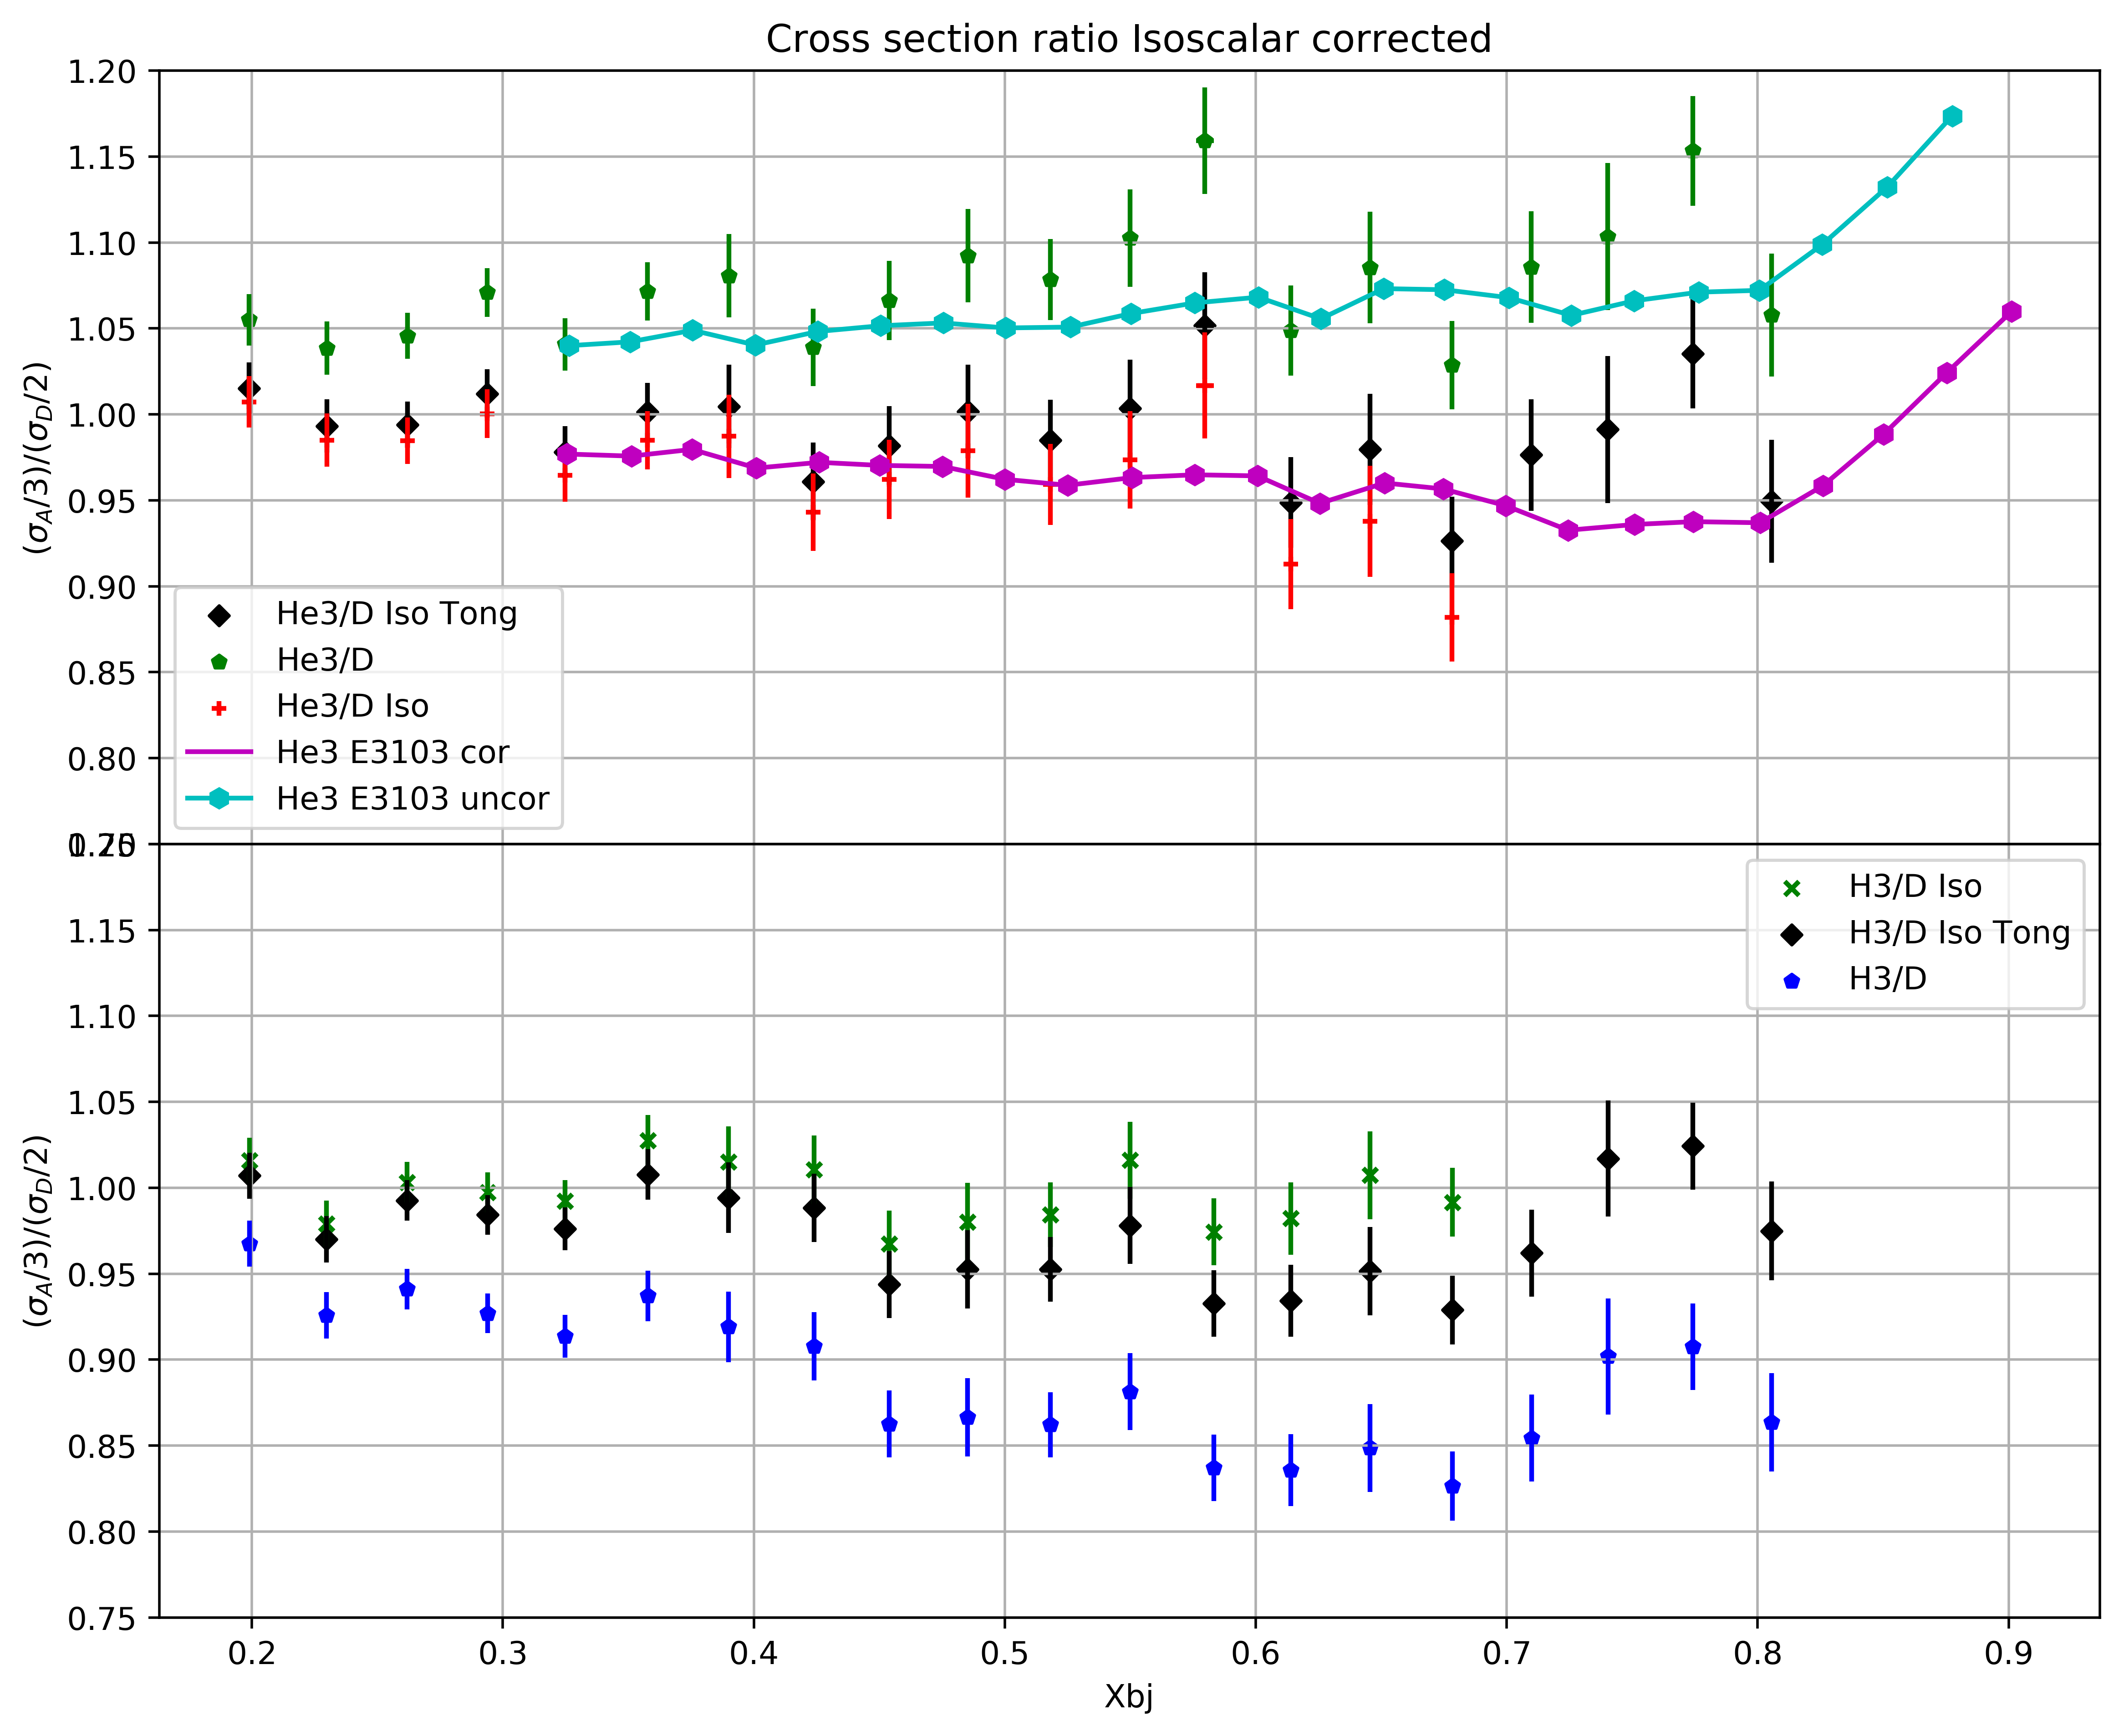

In [150]:

ISO_EMC_both(D2_full,He3_full,H3_full,bins)


Data file does not exist
start second loop
1


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=51,54 m=2500 fp=0.145600 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=50,55 m=2500 fp=0.145440 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[14.01513323  0.        ]
 [ 0.         10.07921259]]

0 D2_kin1
11


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=50,55 m=2500 fp=0.000006 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=47,58 m=2500 fp=0.000004 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[0.37907966 0.00761063 0.        ]
 [0.09402087 0.2814338  0.11311088]
 [0.         0.04729386 0.20304813]]

1 D2_kin11
13


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,56 m=2500 fp=0.000001 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=52,53 m=2500 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[0.1918977  0.12386828 0.         0.        ]
 [0.         0.14082296 0.08642561 0.        ]
 [0.         0.0339438  0.09842001 0.08912774]
 [0.         0.         0.06896937 0.06930699]]

2 D2_kin13
15

[[0.09130482 0.08277024 0.         0.        ]
 [0.04677571 0.0655291  0.0578065  0.        ]
 [0.         0.040861   0.04493842 0.03844346]
 [0.         0.         0.03145161 0.02988788]]

3 D2_kin15
2


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,56 m=2500 fp=0.043249 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=48,57 m=2500 fp=0.040272 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[9.75244401 0.        ]
 [0.         7.28830974]]

5 D2_kin2
3


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=52,53 m=2500 fp=0.015354 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=51,54 m=2500 fp=0.013550 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable c


[[5.3689347  0.        ]
 [0.         4.07212036]]

6 D2_kin3
4


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,56 m=2500 fp=0.004160 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=48,57 m=2500 fp=0.001807 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[4.00432785 0.        ]
 [0.         3.01881146]]

7 D2_kin4
5


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=47,58 m=2500 fp=0.001419 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=47,58 m=2500 fp=0.000256 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[2.9911199  0.        ]
 [0.         2.26444376]]

8 D2_kin5
7


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=48,57 m=2500 fp=0.000196 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=50,55 m=2500 fp=0.000044 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[1.6578527  0.         0.        ]
 [0.         1.28377989 0.10627168]
 [0.         0.04547203 0.97039269]]

9 D2_kin7
9


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=48,57 m=2500 fp=0.000032 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[0.90944786 0.20092952 0.        ]
 [0.21446103 0.71298191 0.09282542]
 [0.         0.05431994 0.53056853]]

10 D2_kin9
start second loop
1


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,56 m=2500 fp=0.366705 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=50,55 m=2500 fp=0.426432 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable c


[[22.030079    0.        ]
 [ 0.         15.89162918]]

0 He3_kin1
11


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=52,53 m=2500 fp=0.000016 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=48,57 m=2500 fp=0.000005 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[0.62911153 0.         0.        ]
 [0.24675336 0.46715132 0.13400778]
 [0.         0.05650516 0.3367163 ]]

1 He3_kin11
13


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=52,53 m=2500 fp=0.000004 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[0.31963017 0.24830013 0.         0.        ]
 [0.13874637 0.23451421 0.19972895 0.        ]
 [0.         0.07561022 0.16351419 0.13639179]
 [0.         0.         0.12553155 0.11473185]]

2 He3_kin13
15


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=54,51 m=2500 fp=0.000002 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=52,53 m=2500 fp=0.000002 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[0.15159647 0.13708103 0.         0.        ]
 [0.10023828 0.10856119 0.09547954 0.        ]
 [0.         0.08133745 0.07403499 0.06169564]
 [0.         0.         0.05673142 0.04915883]]

3 He3_kin15
2


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,56 m=2500 fp=0.109540 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=52,53 m=2500 fp=0.122895 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[15.44100978  0.        ]
 [ 0.         11.58944911]]

4 He3_kin2
3


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,56 m=2500 fp=0.039820 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=50,55 m=2500 fp=0.035879 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable c


[[8.60334278 0.        ]
 [0.         6.53092573]]

5 He3_kin3
4


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=51,54 m=2500 fp=0.011874 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=51,54 m=2500 fp=0.005096 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[6.44591241 0.        ]
 [0.         4.86759843]]

6 He3_kin4
5


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=51,54 m=2500 fp=0.004644 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=50,55 m=2500 fp=0.000757 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[4.83457893 0.        ]
 [0.         3.66735174]]

7 He3_kin5
7


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=50,55 m=2500 fp=0.000816 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[2.70844233 0.         0.        ]
 [0.         2.10053642 0.19270348]
 [0.         0.01556434 1.59154424]]

8 He3_kin7
9


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=50,55 m=2500 fp=0.000127 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=50,55 m=2500 fp=0.000138 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[1.49416695 0.34584573 0.         0.        ]
 [0.32308251 1.17681048 0.13819959 0.        ]
 [0.         0.         0.87648011 0.2394883 ]
 [0.         0.         0.22638533 0.66640946]]

9 He3_kin9
start second loop
1


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,56 m=2500 fp=0.292795 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,56 m=2500 fp=0.342407 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable c


[[20.07321801  0.        ]
 [ 0.         14.34090337]]

0 H3_kin1
11


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,56 m=2500 fp=0.000012 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[0.49223811 0.0186637  0.        ]
 [0.09311313 0.36258807 0.14199873]
 [0.         0.10205594 0.26012333]]

1 H3_kin11
13


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=50,55 m=2500 fp=0.000003 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,56 m=2500 fp=0.000004 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable c


[[0.24608923 0.14519005 0.         0.        ]
 [0.05102845 0.17982335 0.11243229 0.        ]
 [0.         0.09583629 0.12571507 0.11451765]
 [0.         0.         0.09430108 0.08897652]]

2 H3_kin13
15


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=52,53 m=2500 fp=0.000001 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=51,54 m=2500 fp=0.087491 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[0.11673251 0.10644585 0.         0.        ]
 [0.08981437 0.08400621 0.07486637 0.00036605]
 [0.         0.06086714 0.05832775 0.05098135]
 [0.         0.         0.04459272 0.03943696]]

3 H3_kin15
2


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=51,54 m=2500 fp=0.103455 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[13.85444216  0.        ]
 [ 0.         10.26994274]]

4 H3_kin2
3


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=52,53 m=2500 fp=0.030462 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=50,55 m=2500 fp=0.030210 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[7.50983924 0.        ]
 [0.         5.63282288]]

5 H3_kin3
4


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=50,55 m=2500 fp=0.009344 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[5.55062251 0.        ]
 [0.         4.14039993]]

6 H3_kin4
5


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=48,57 m=2500 fp=0.008798 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,56 m=2500 fp=0.003243 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable c


[[4.10641262 0.        ]
 [0.         3.08394338]]

7 H3_kin5
7


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=51,54 m=2500 fp=0.000481 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[2.23556208 0.         0.        ]
 [0.         1.71930901 0.        ]
 [0.         0.13475542 1.28995821]]

8 H3_kin7
9


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,56 m=2500 fp=0.000073 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=50,55 m=2500 fp=0.000080 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[1.20730748 0.29777345 0.        ]
 [0.23856588 0.94071997 0.        ]
 [0.         0.         0.69471095]]

9 H3_kin9


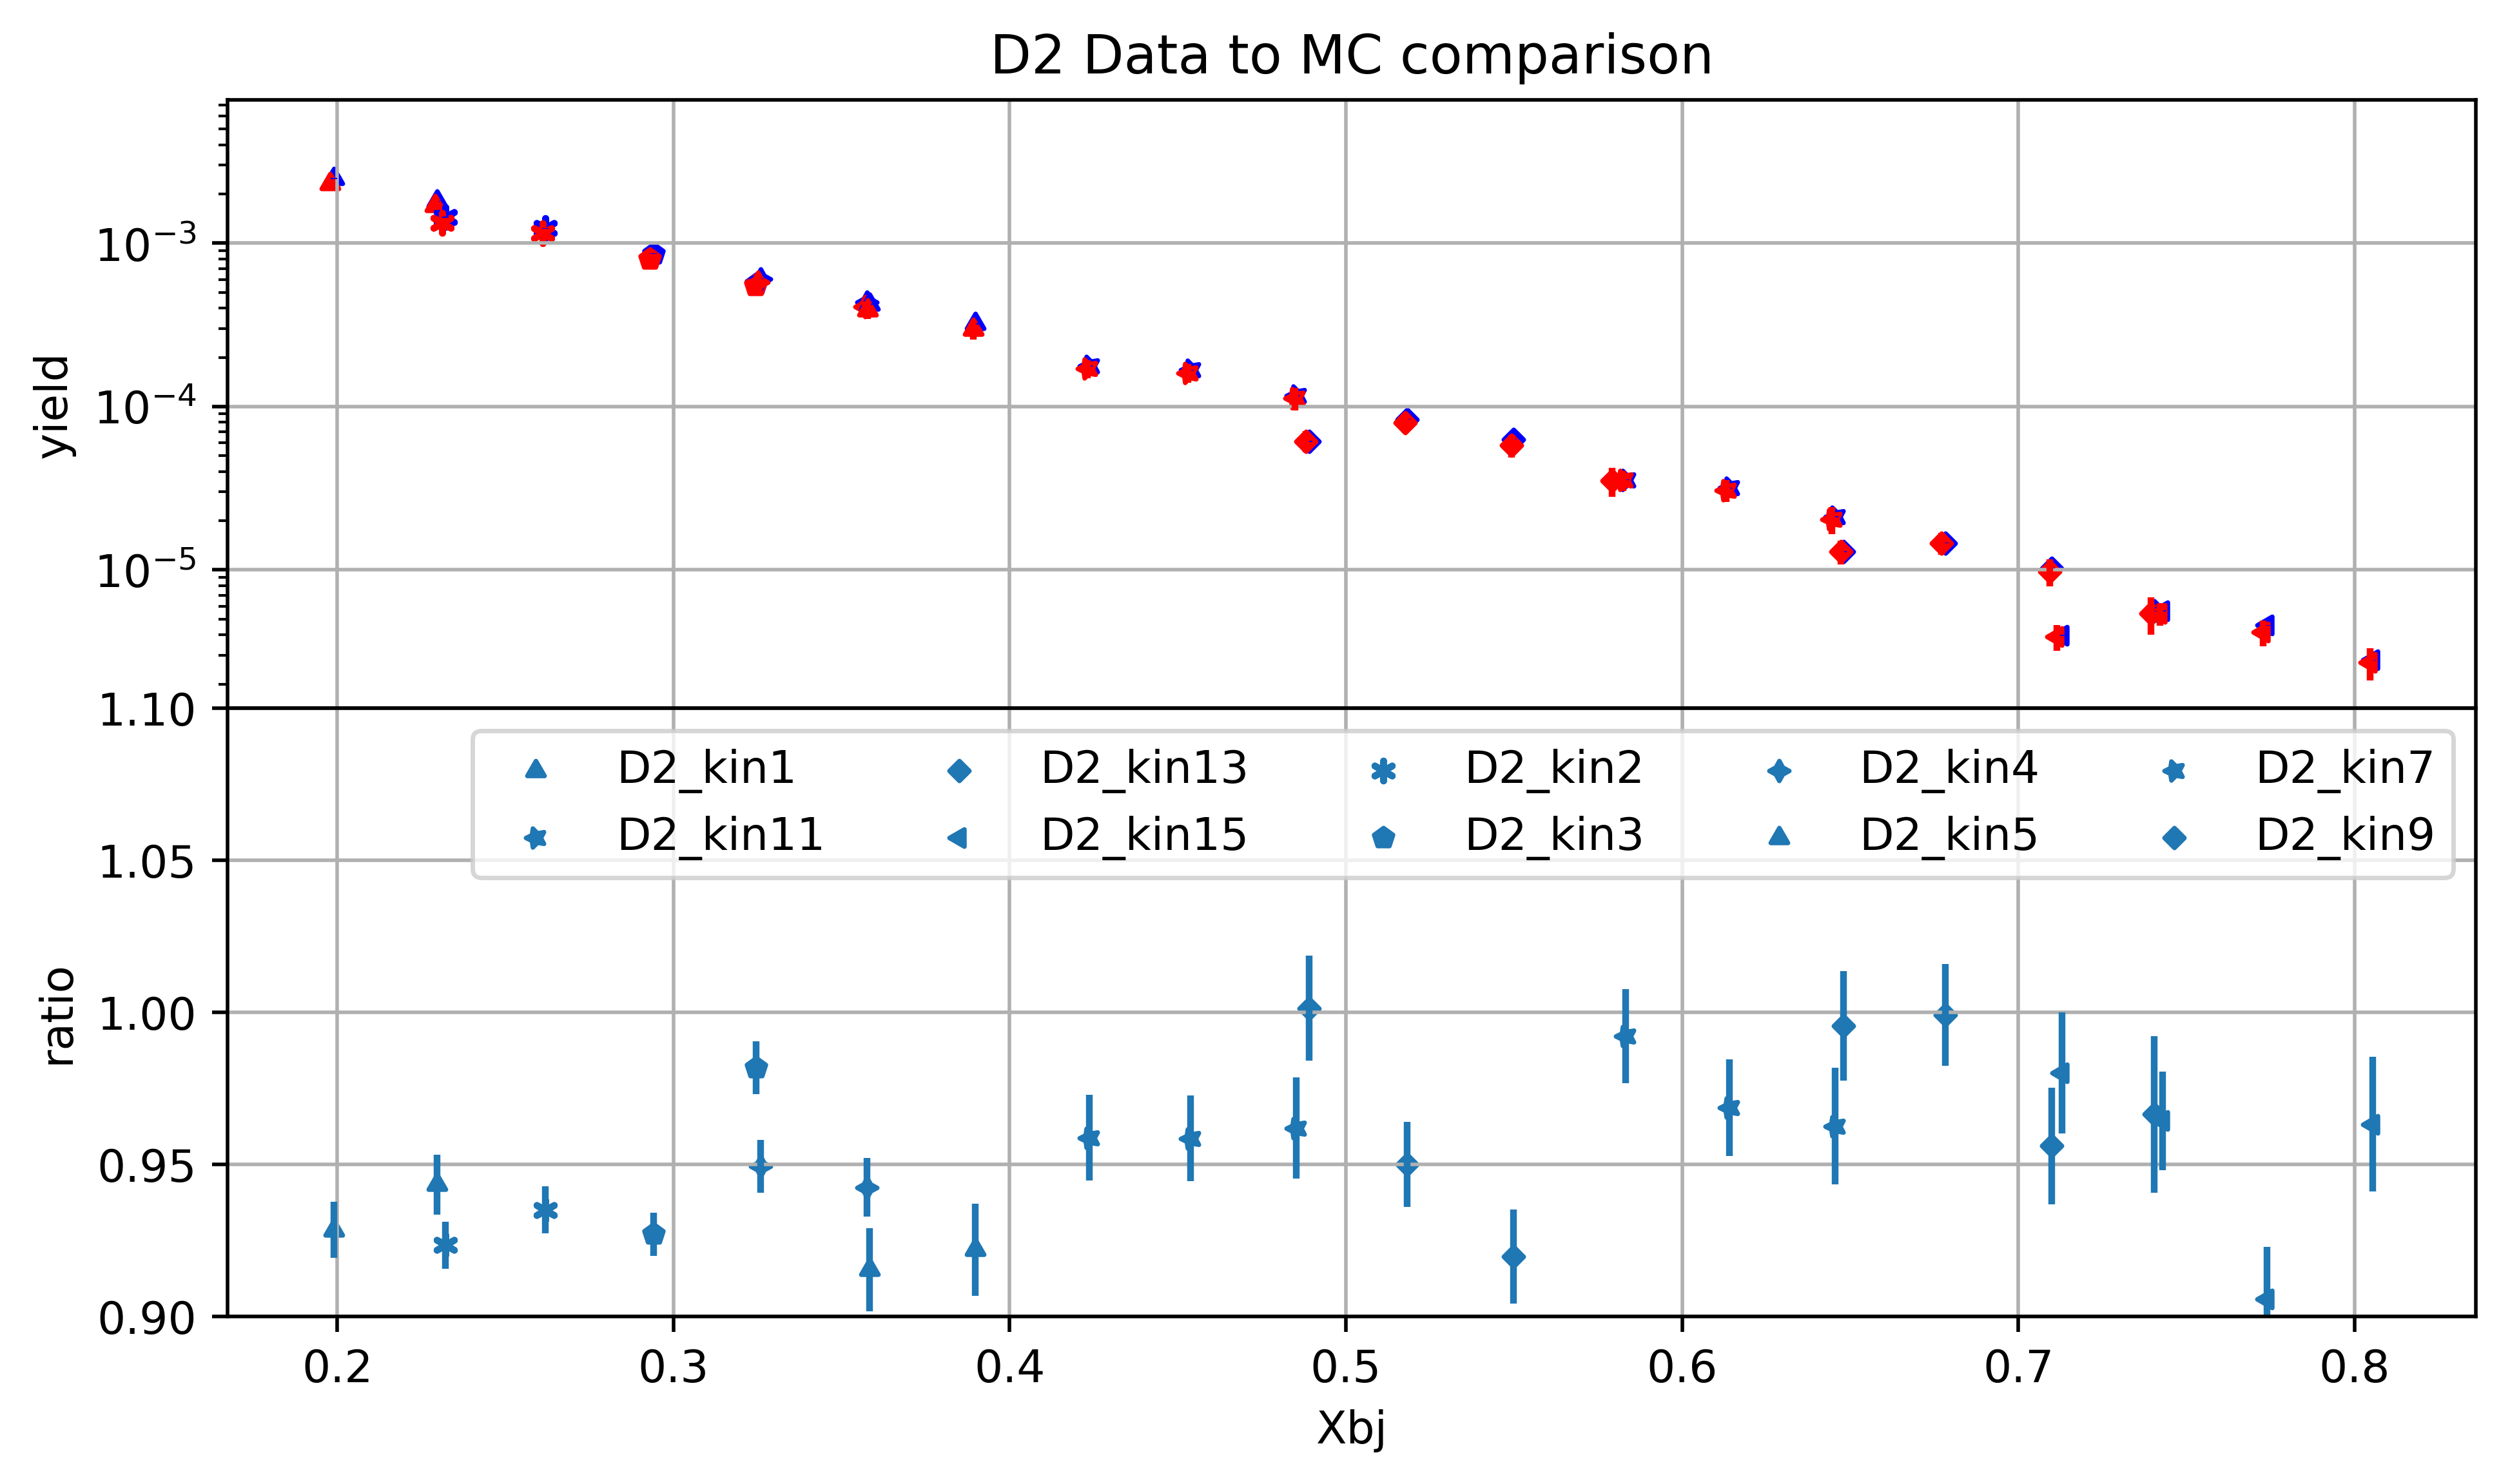

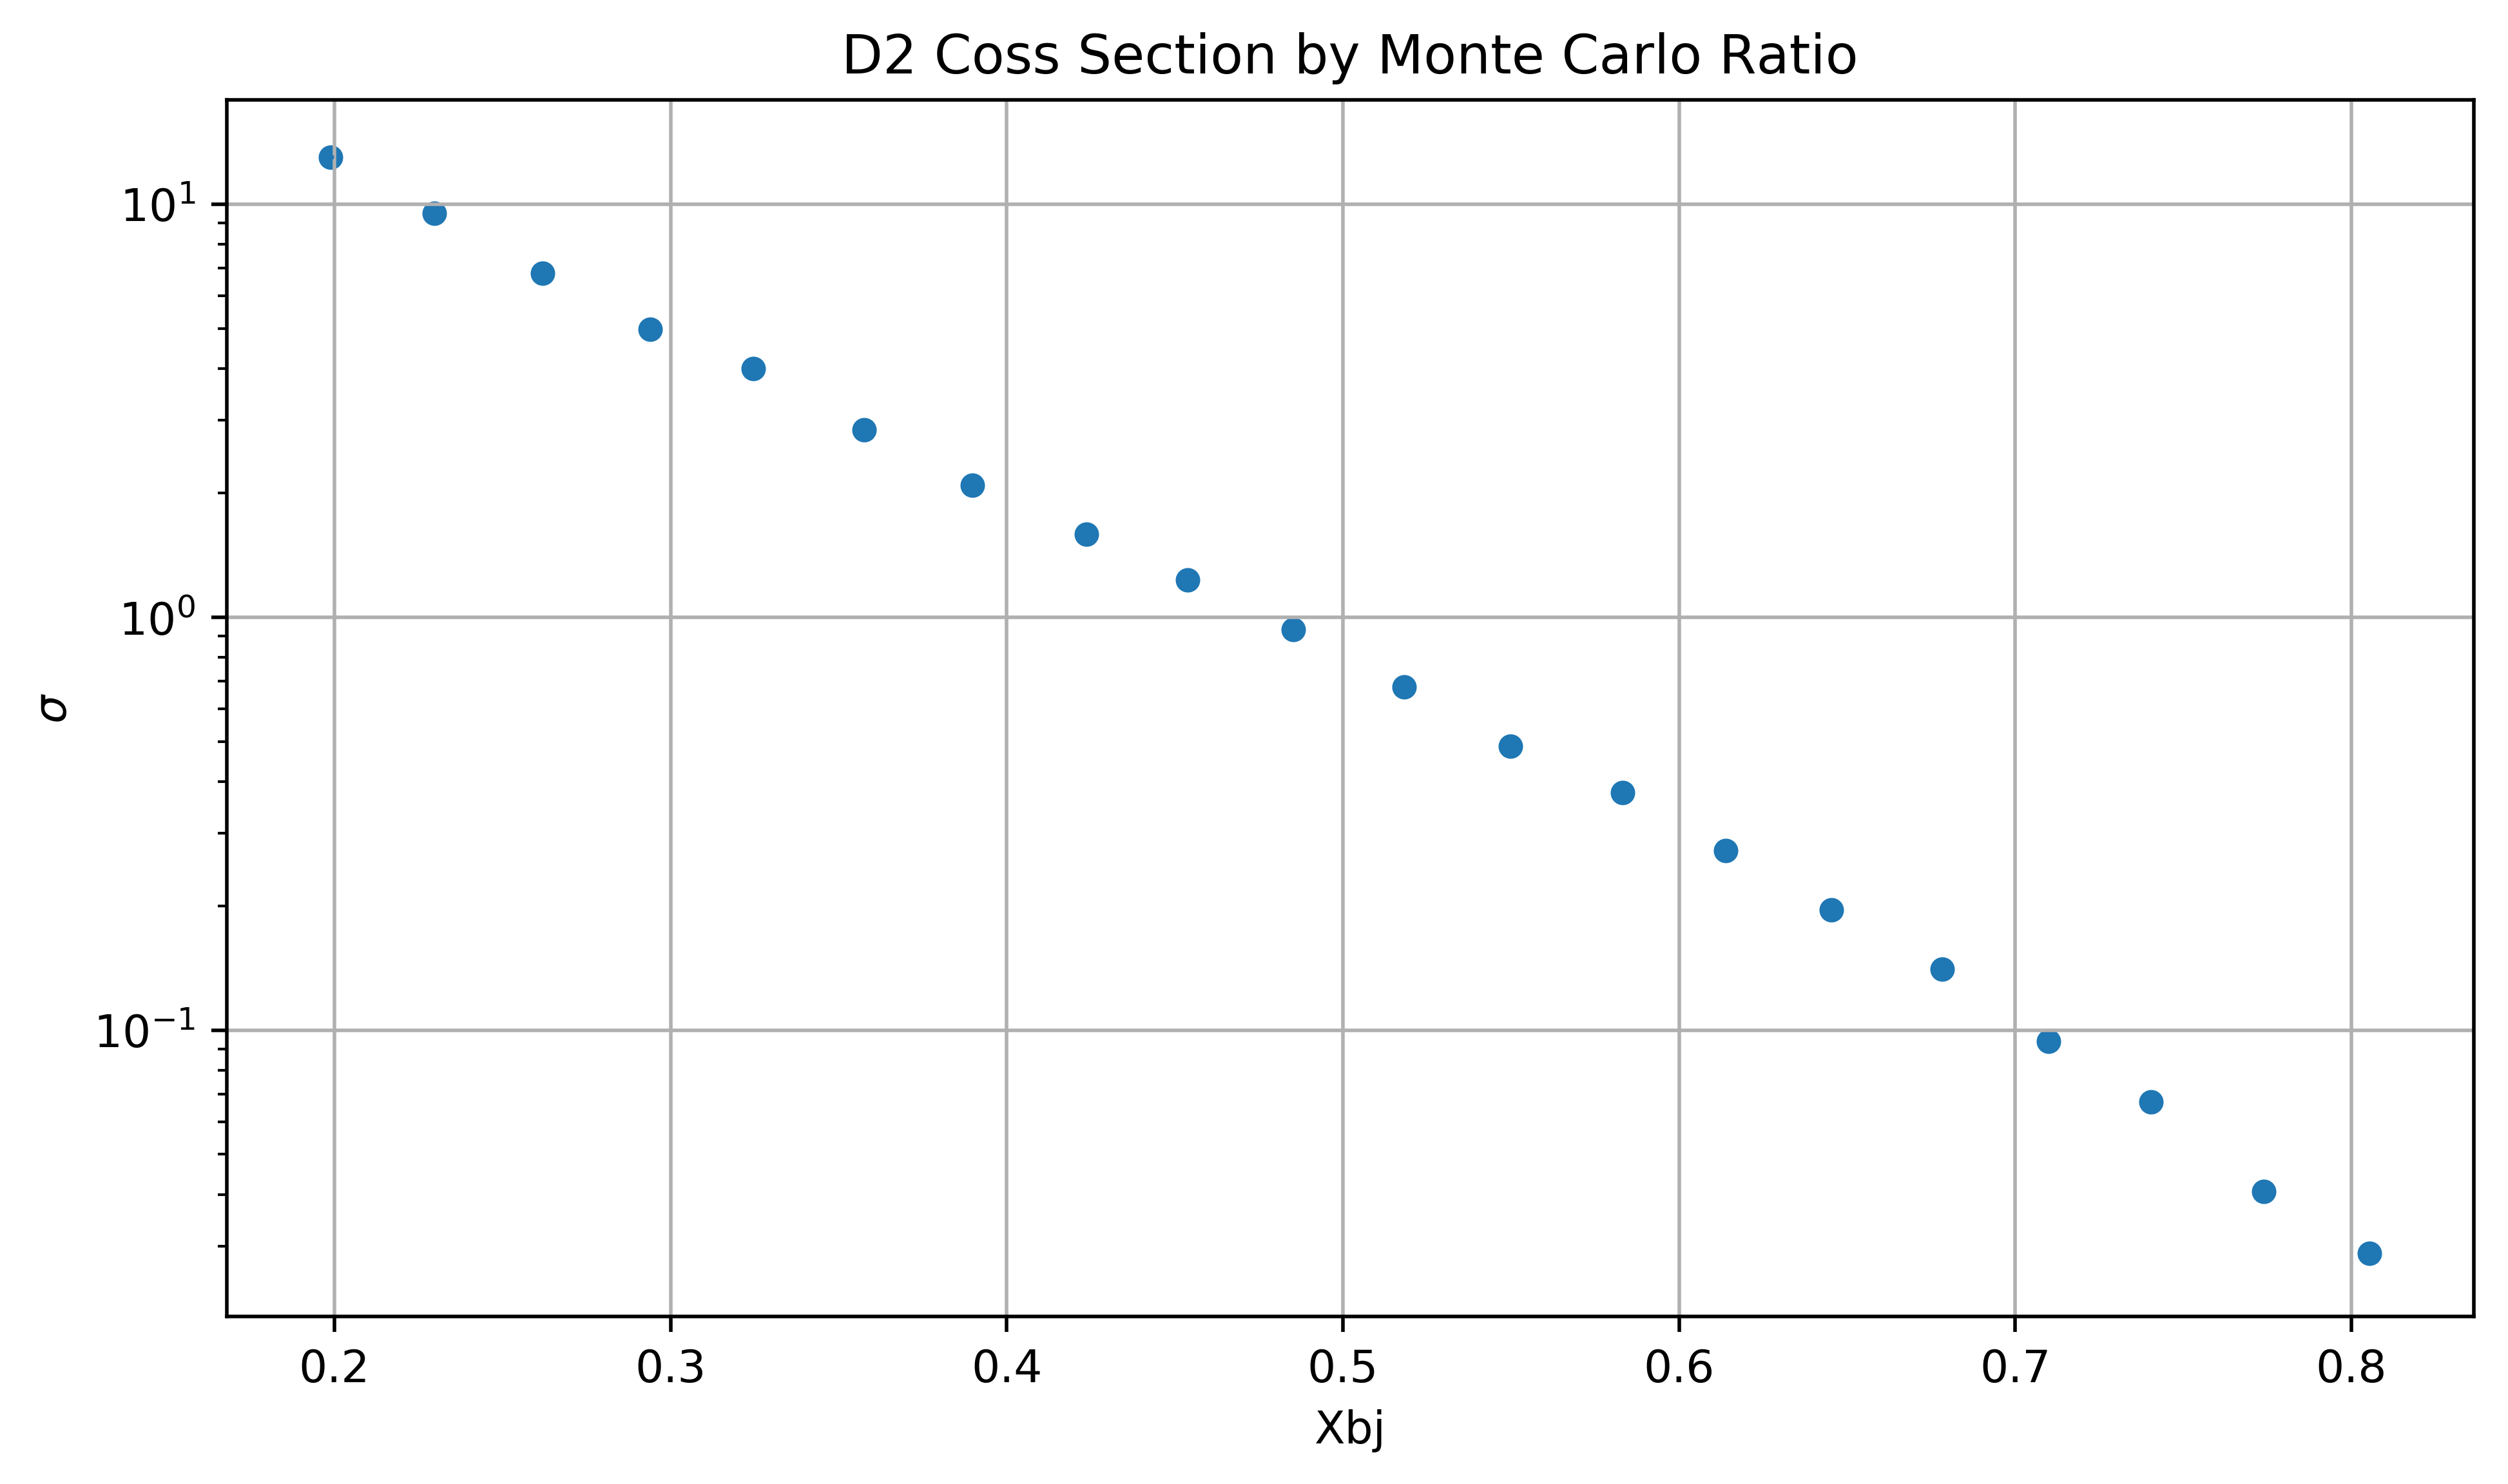

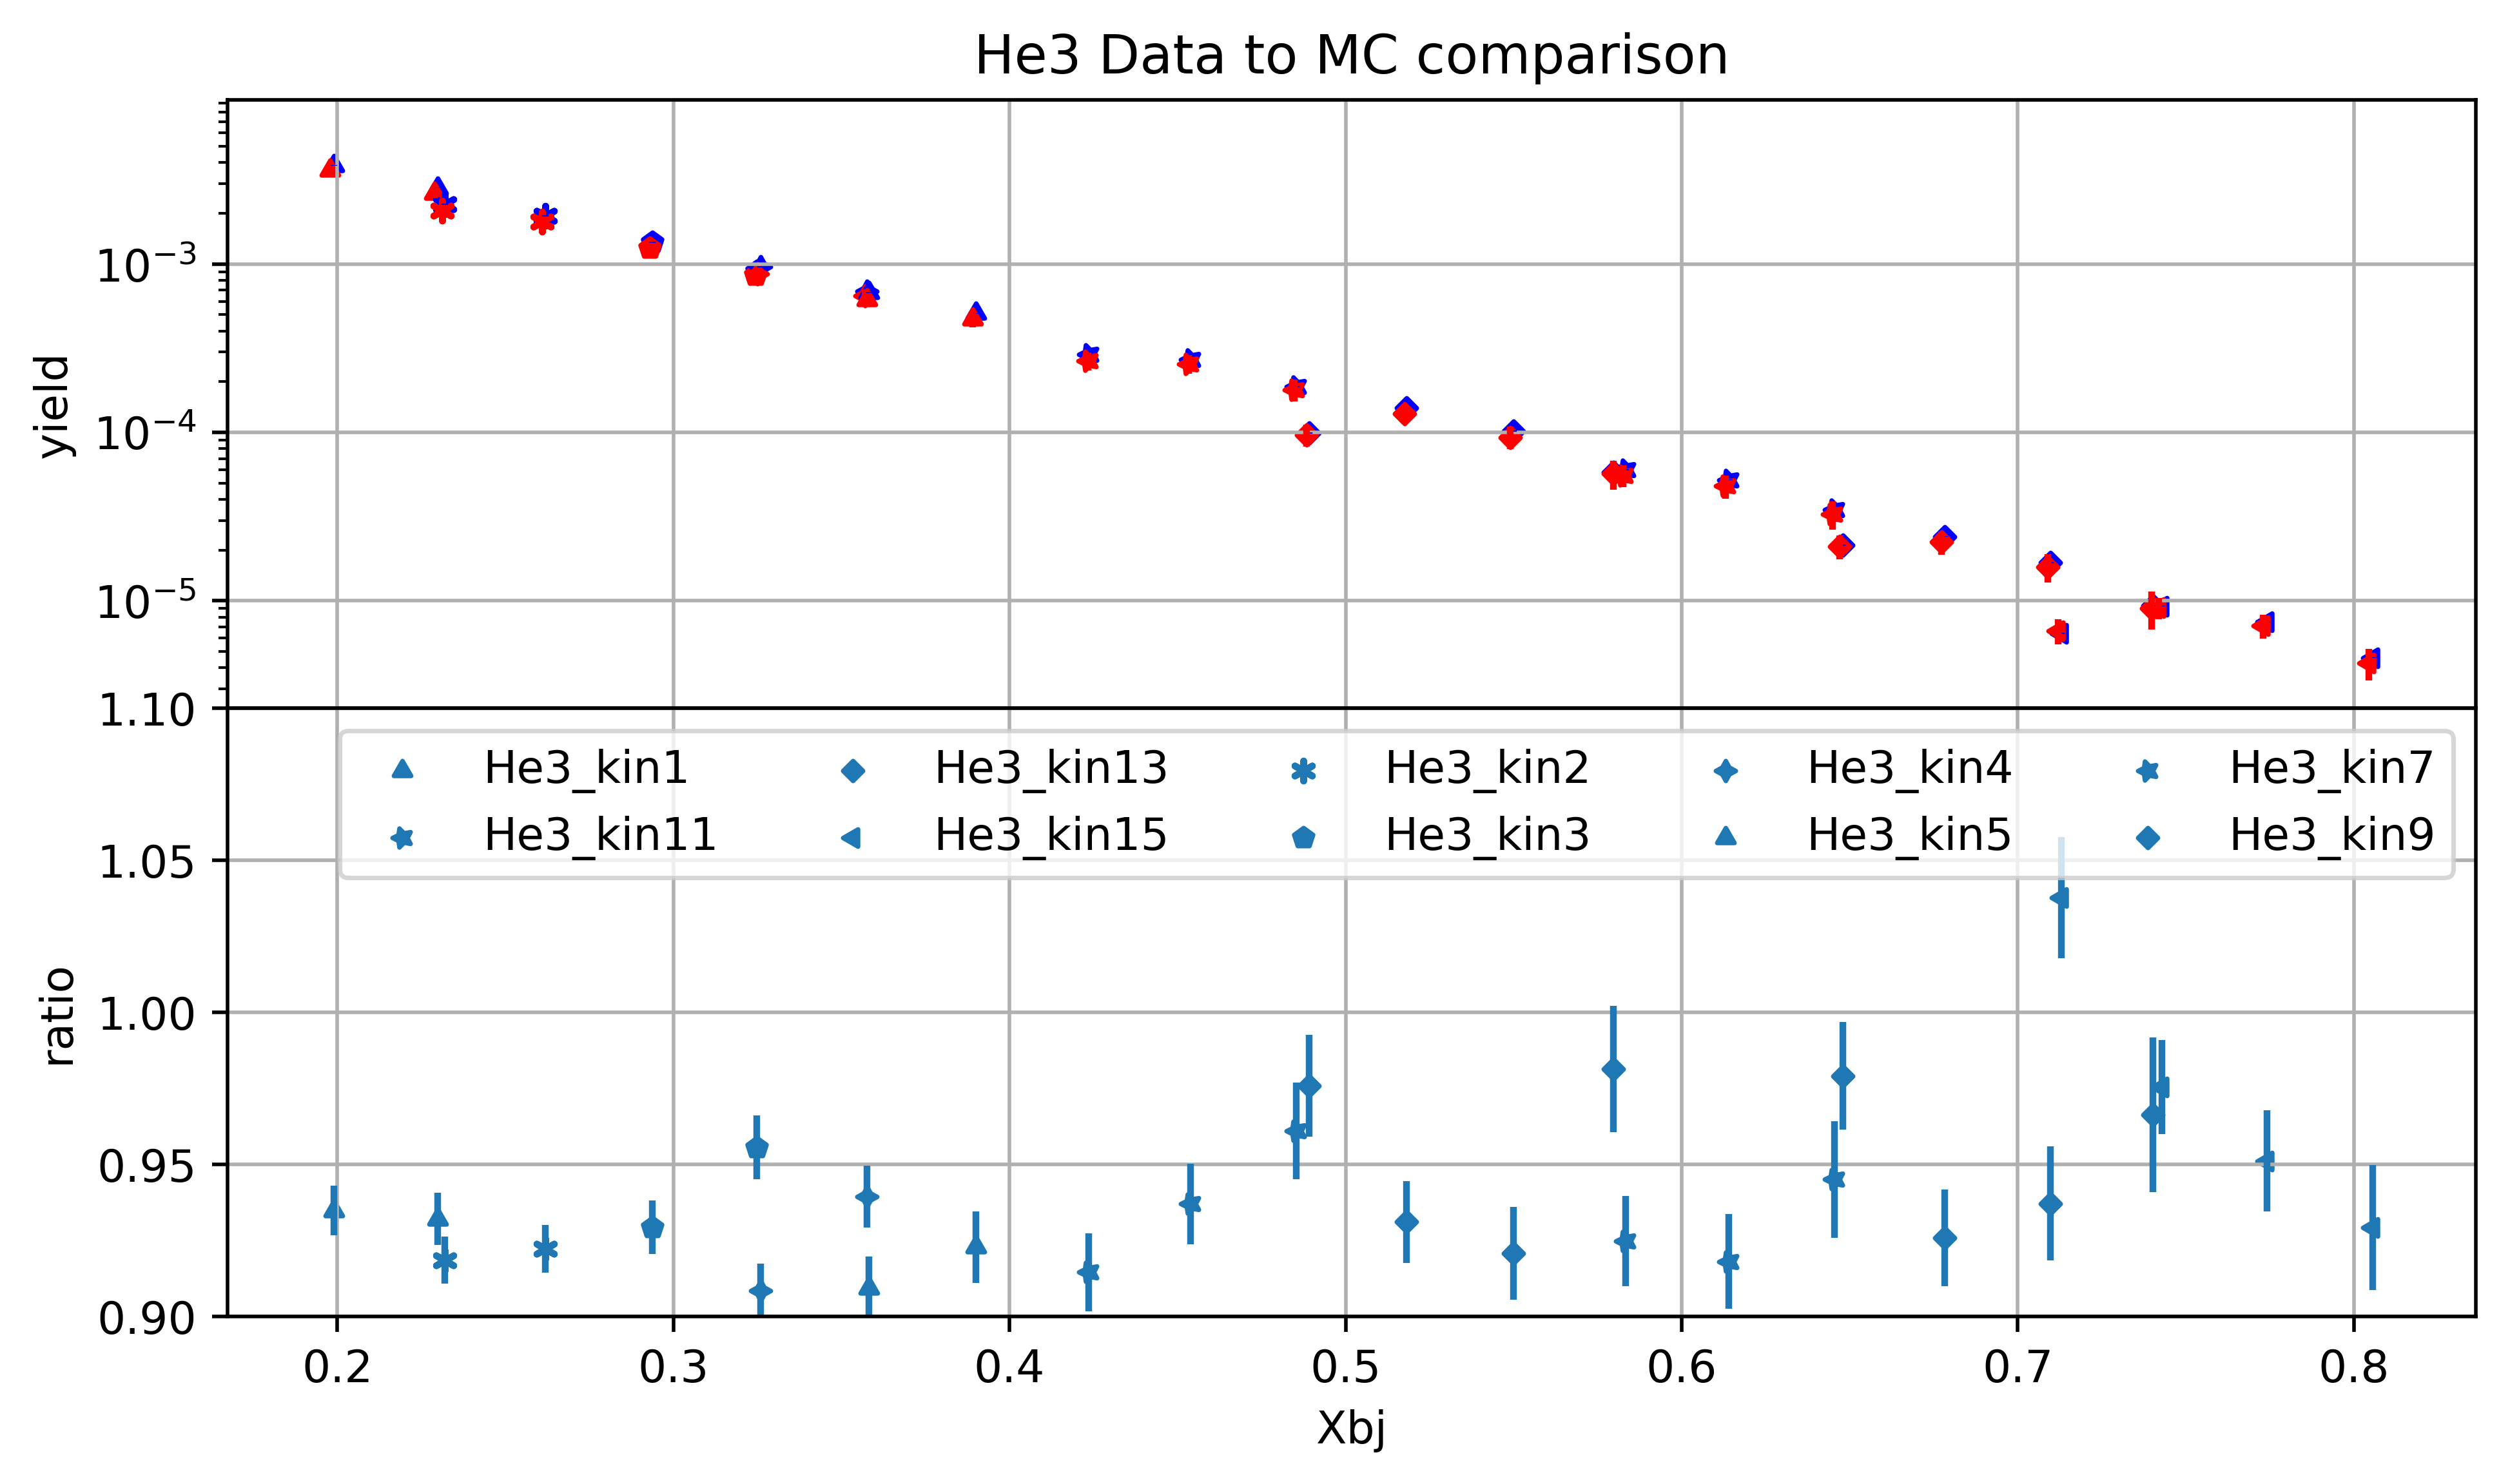

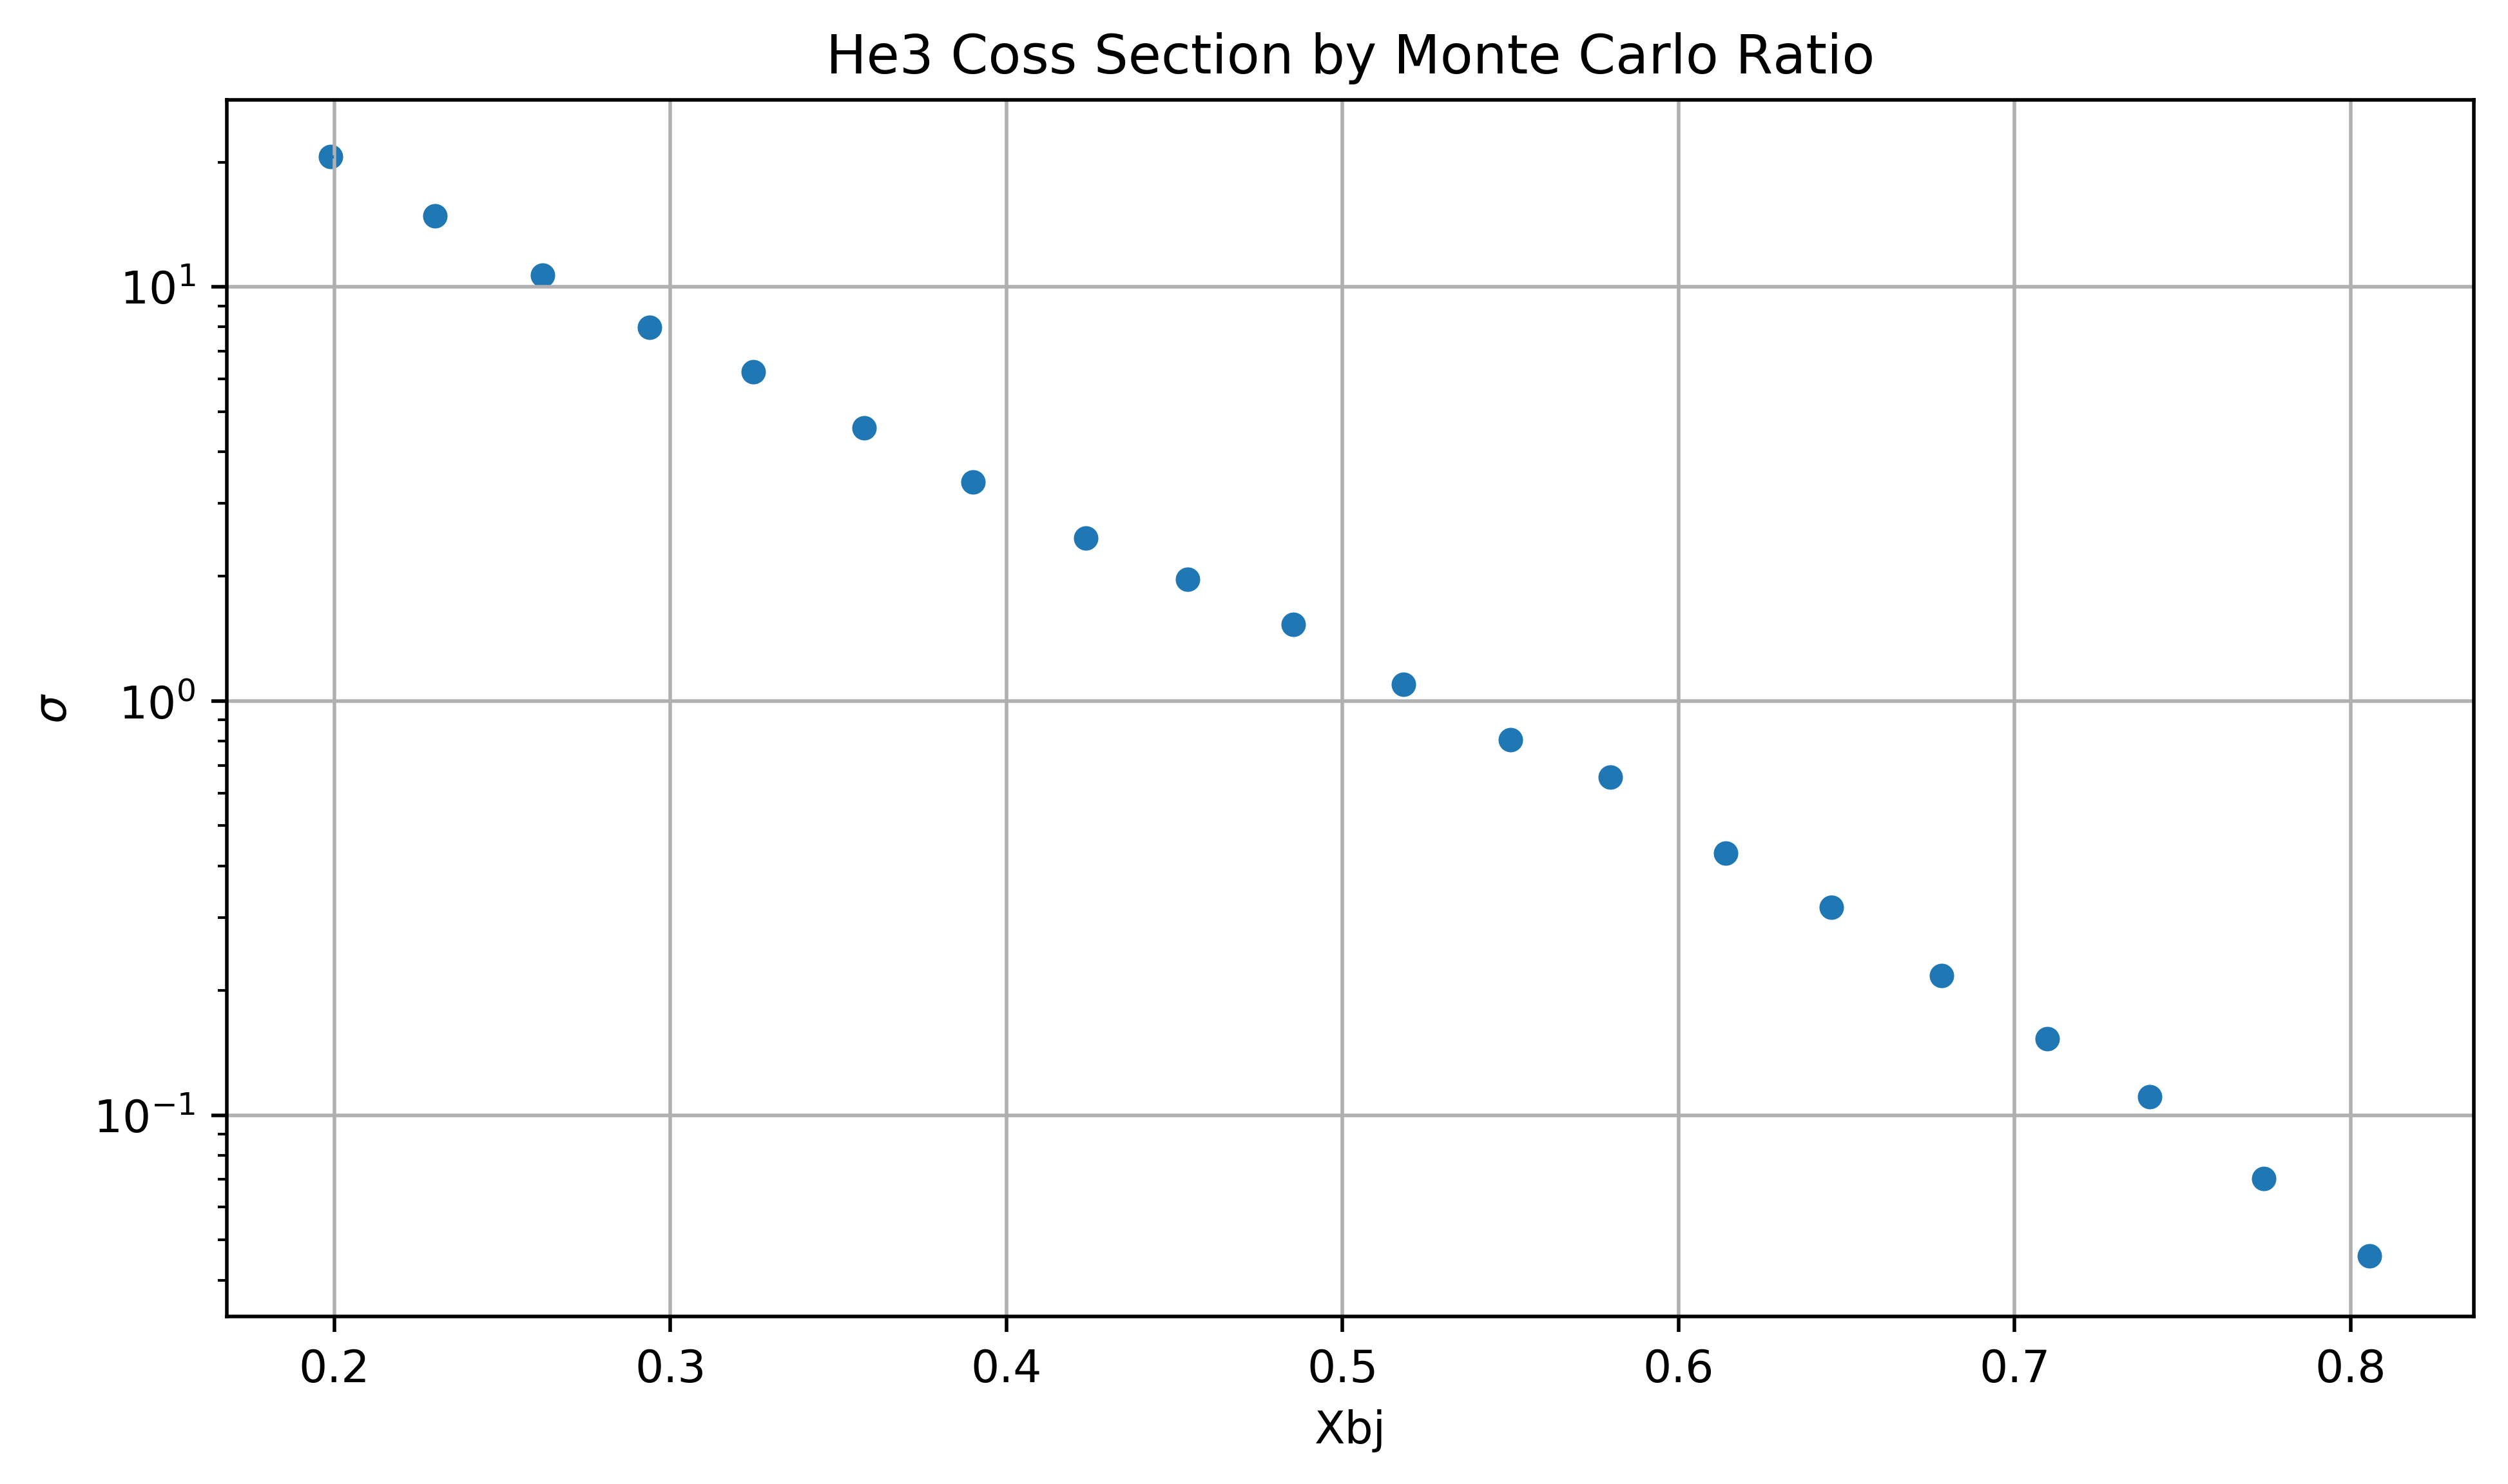

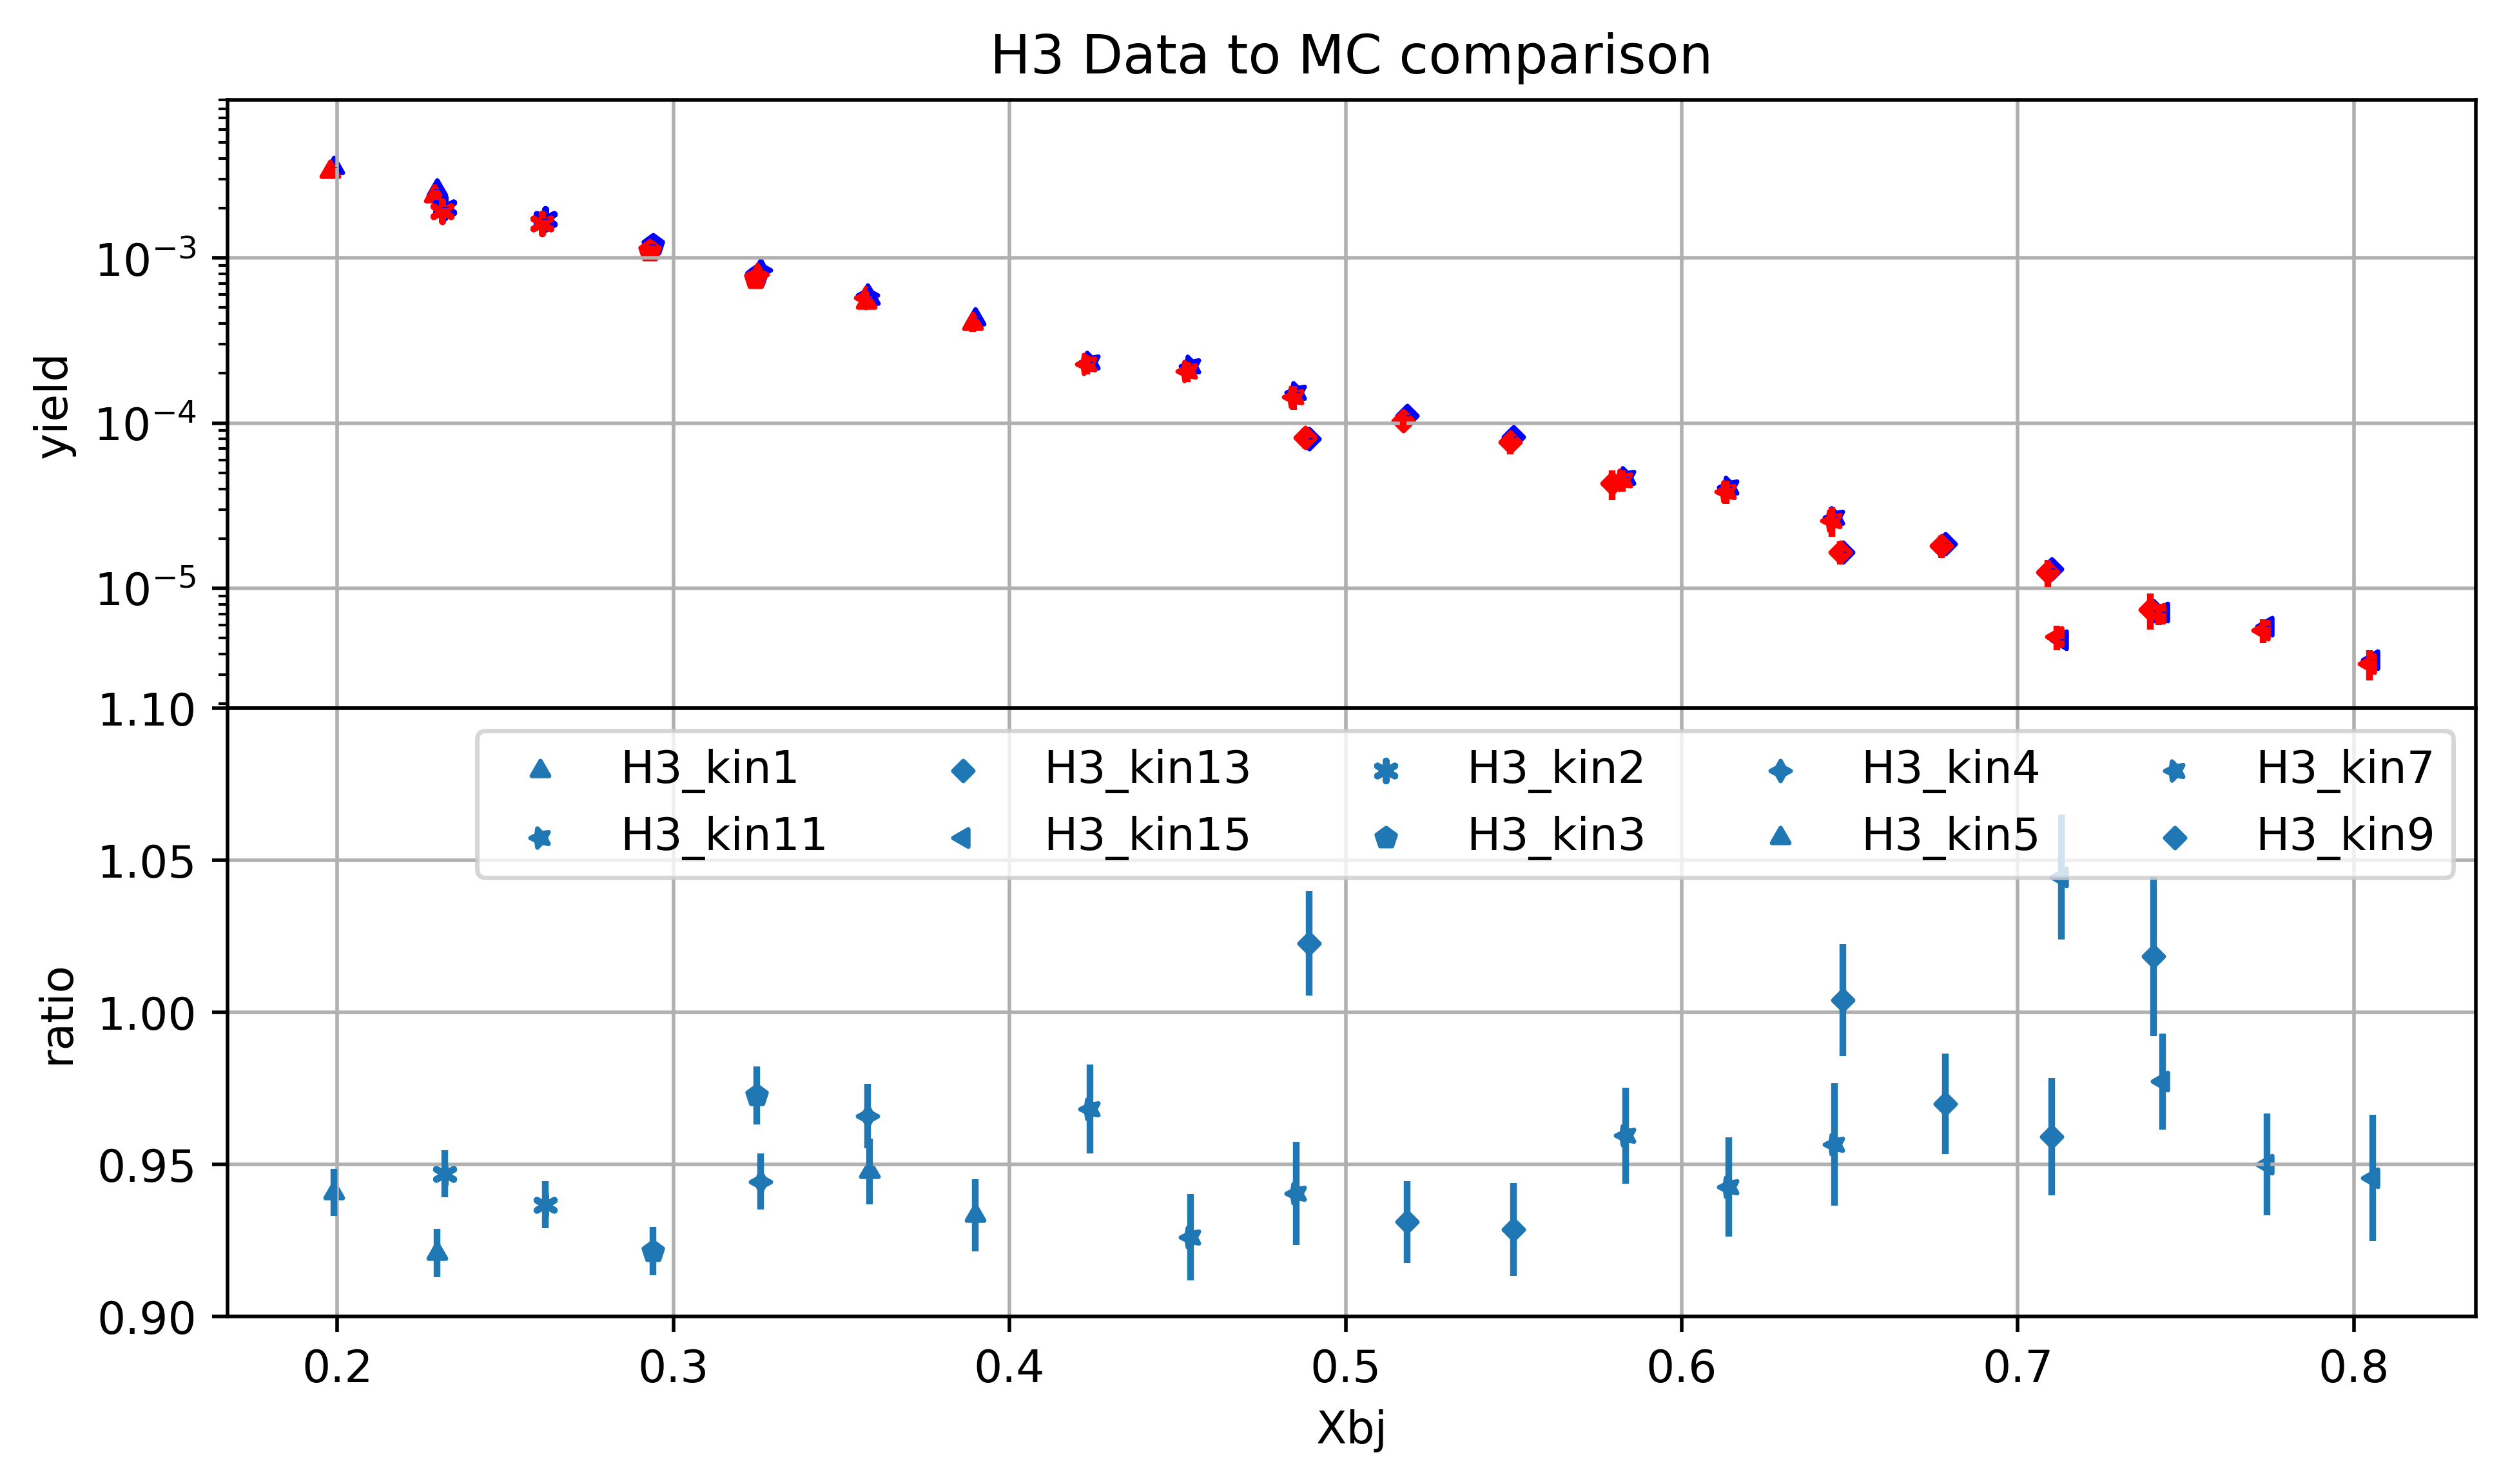

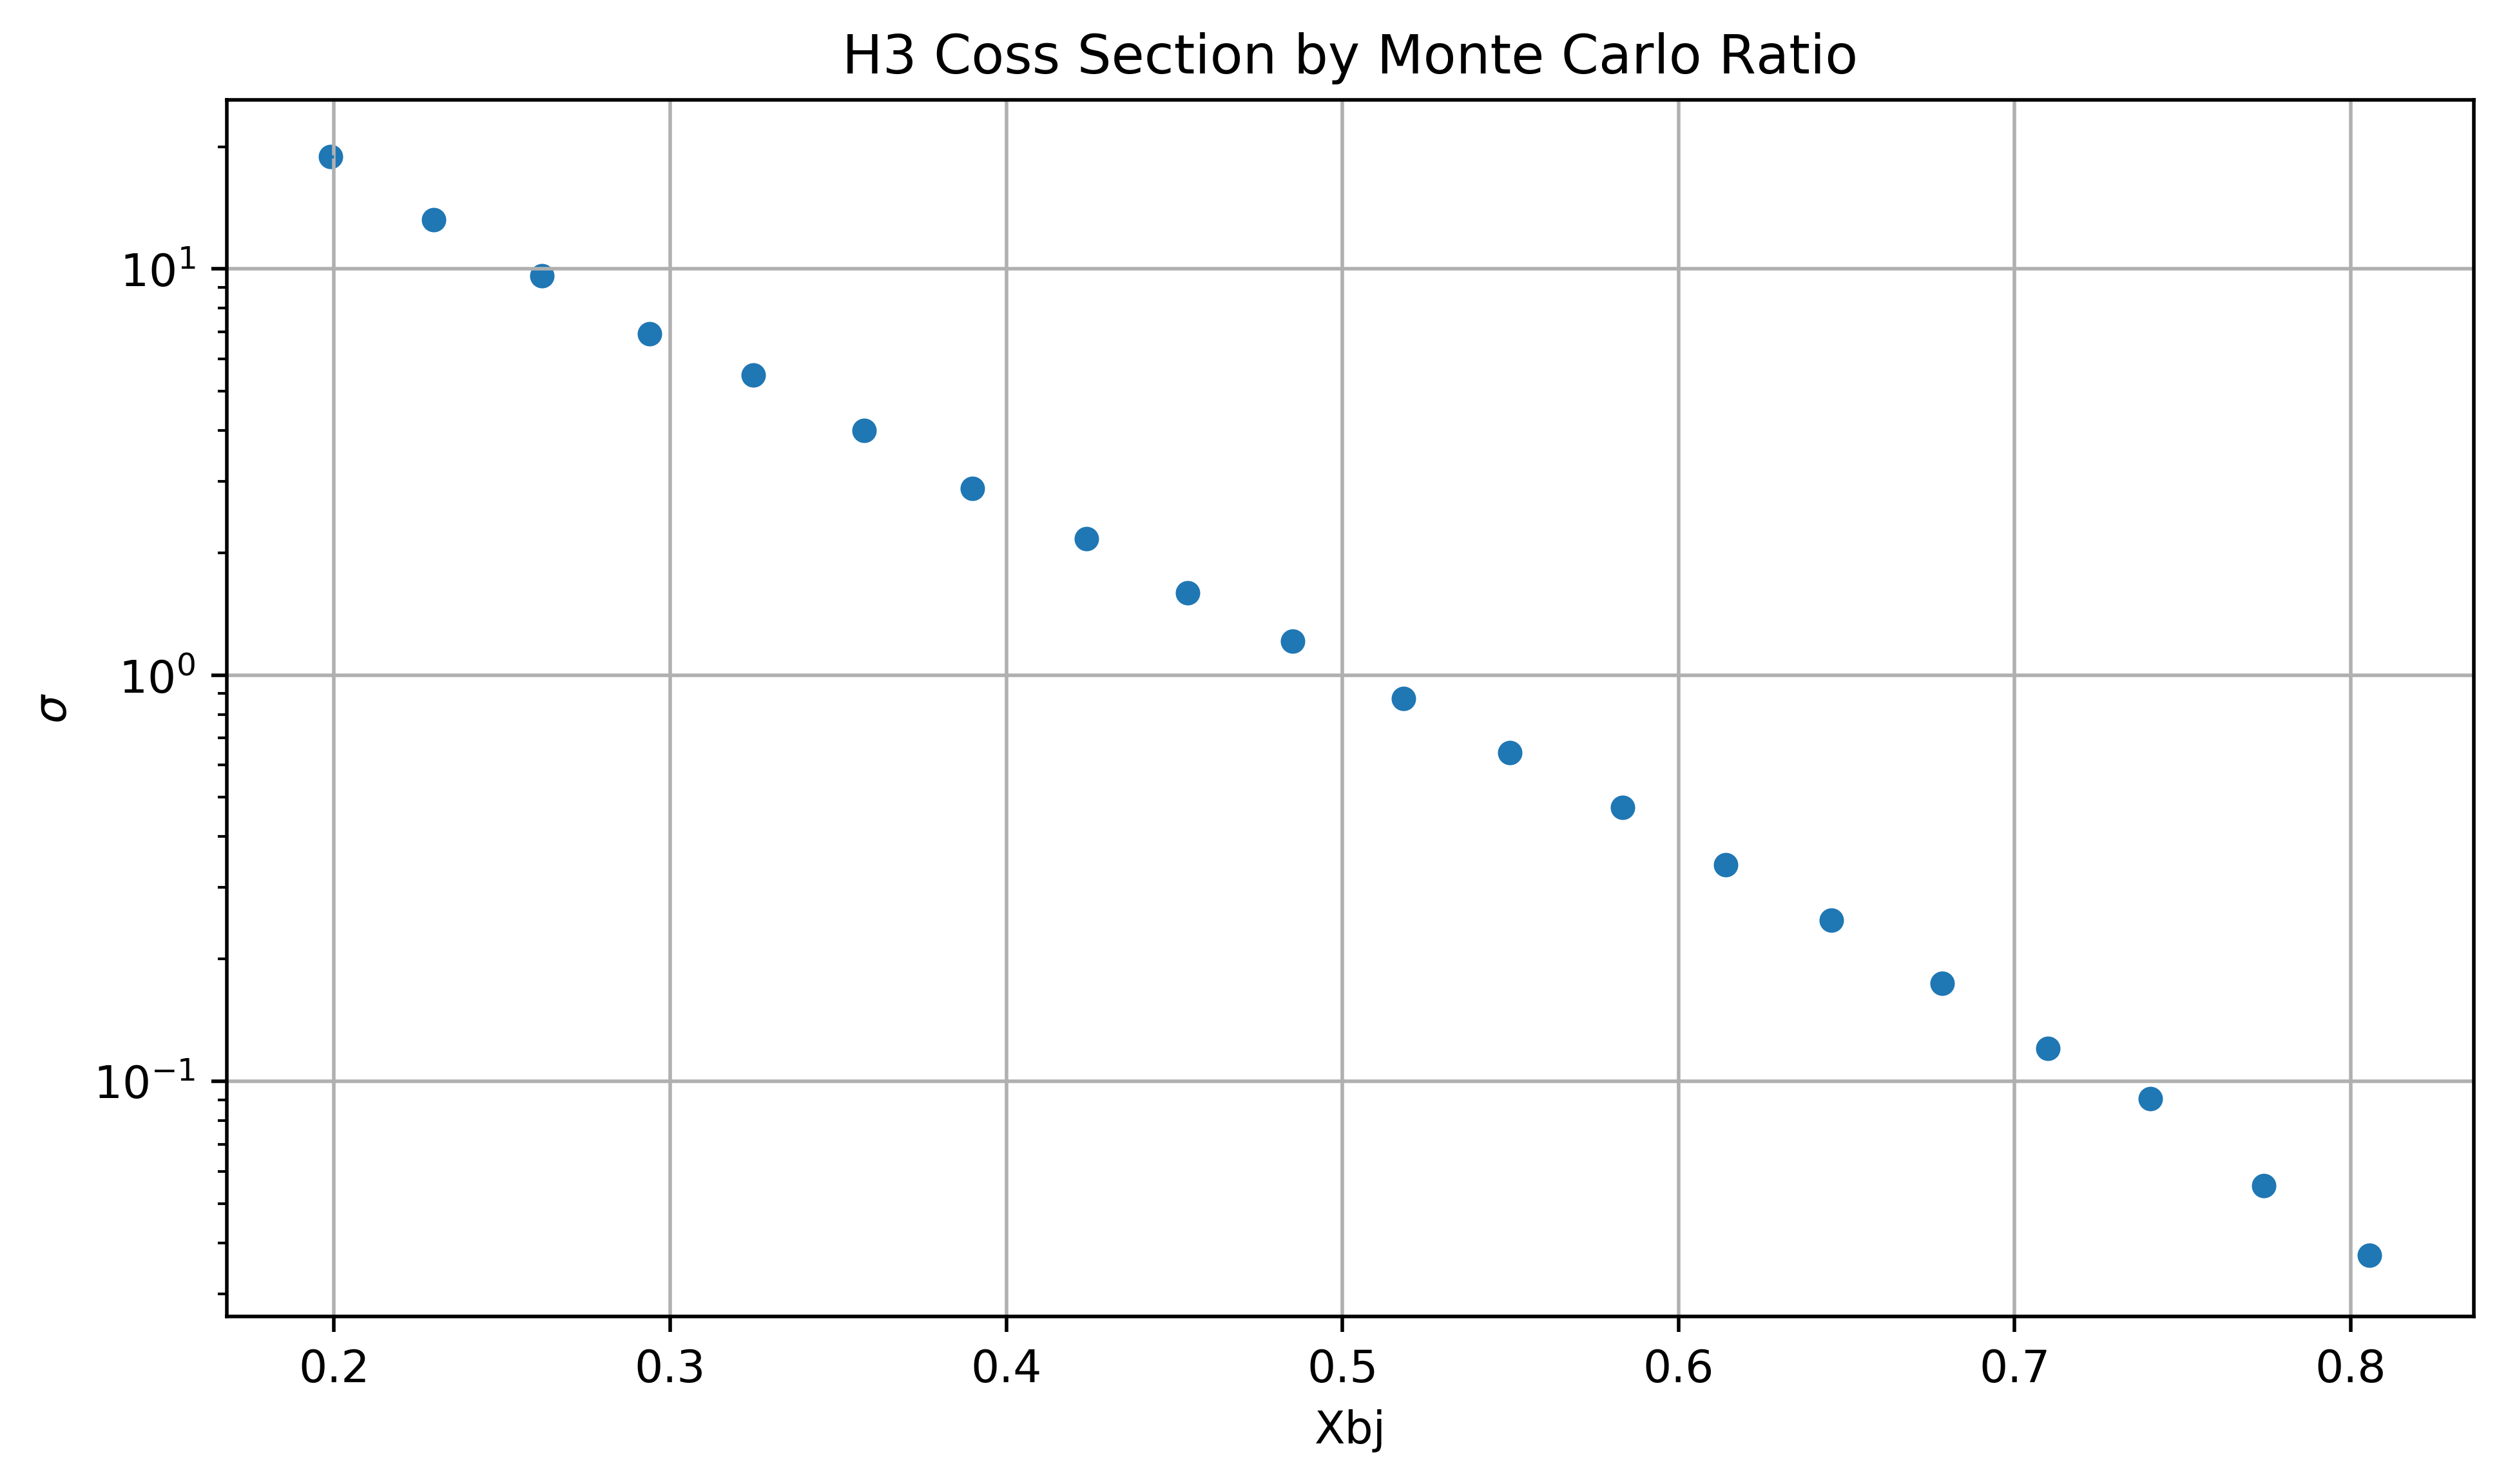

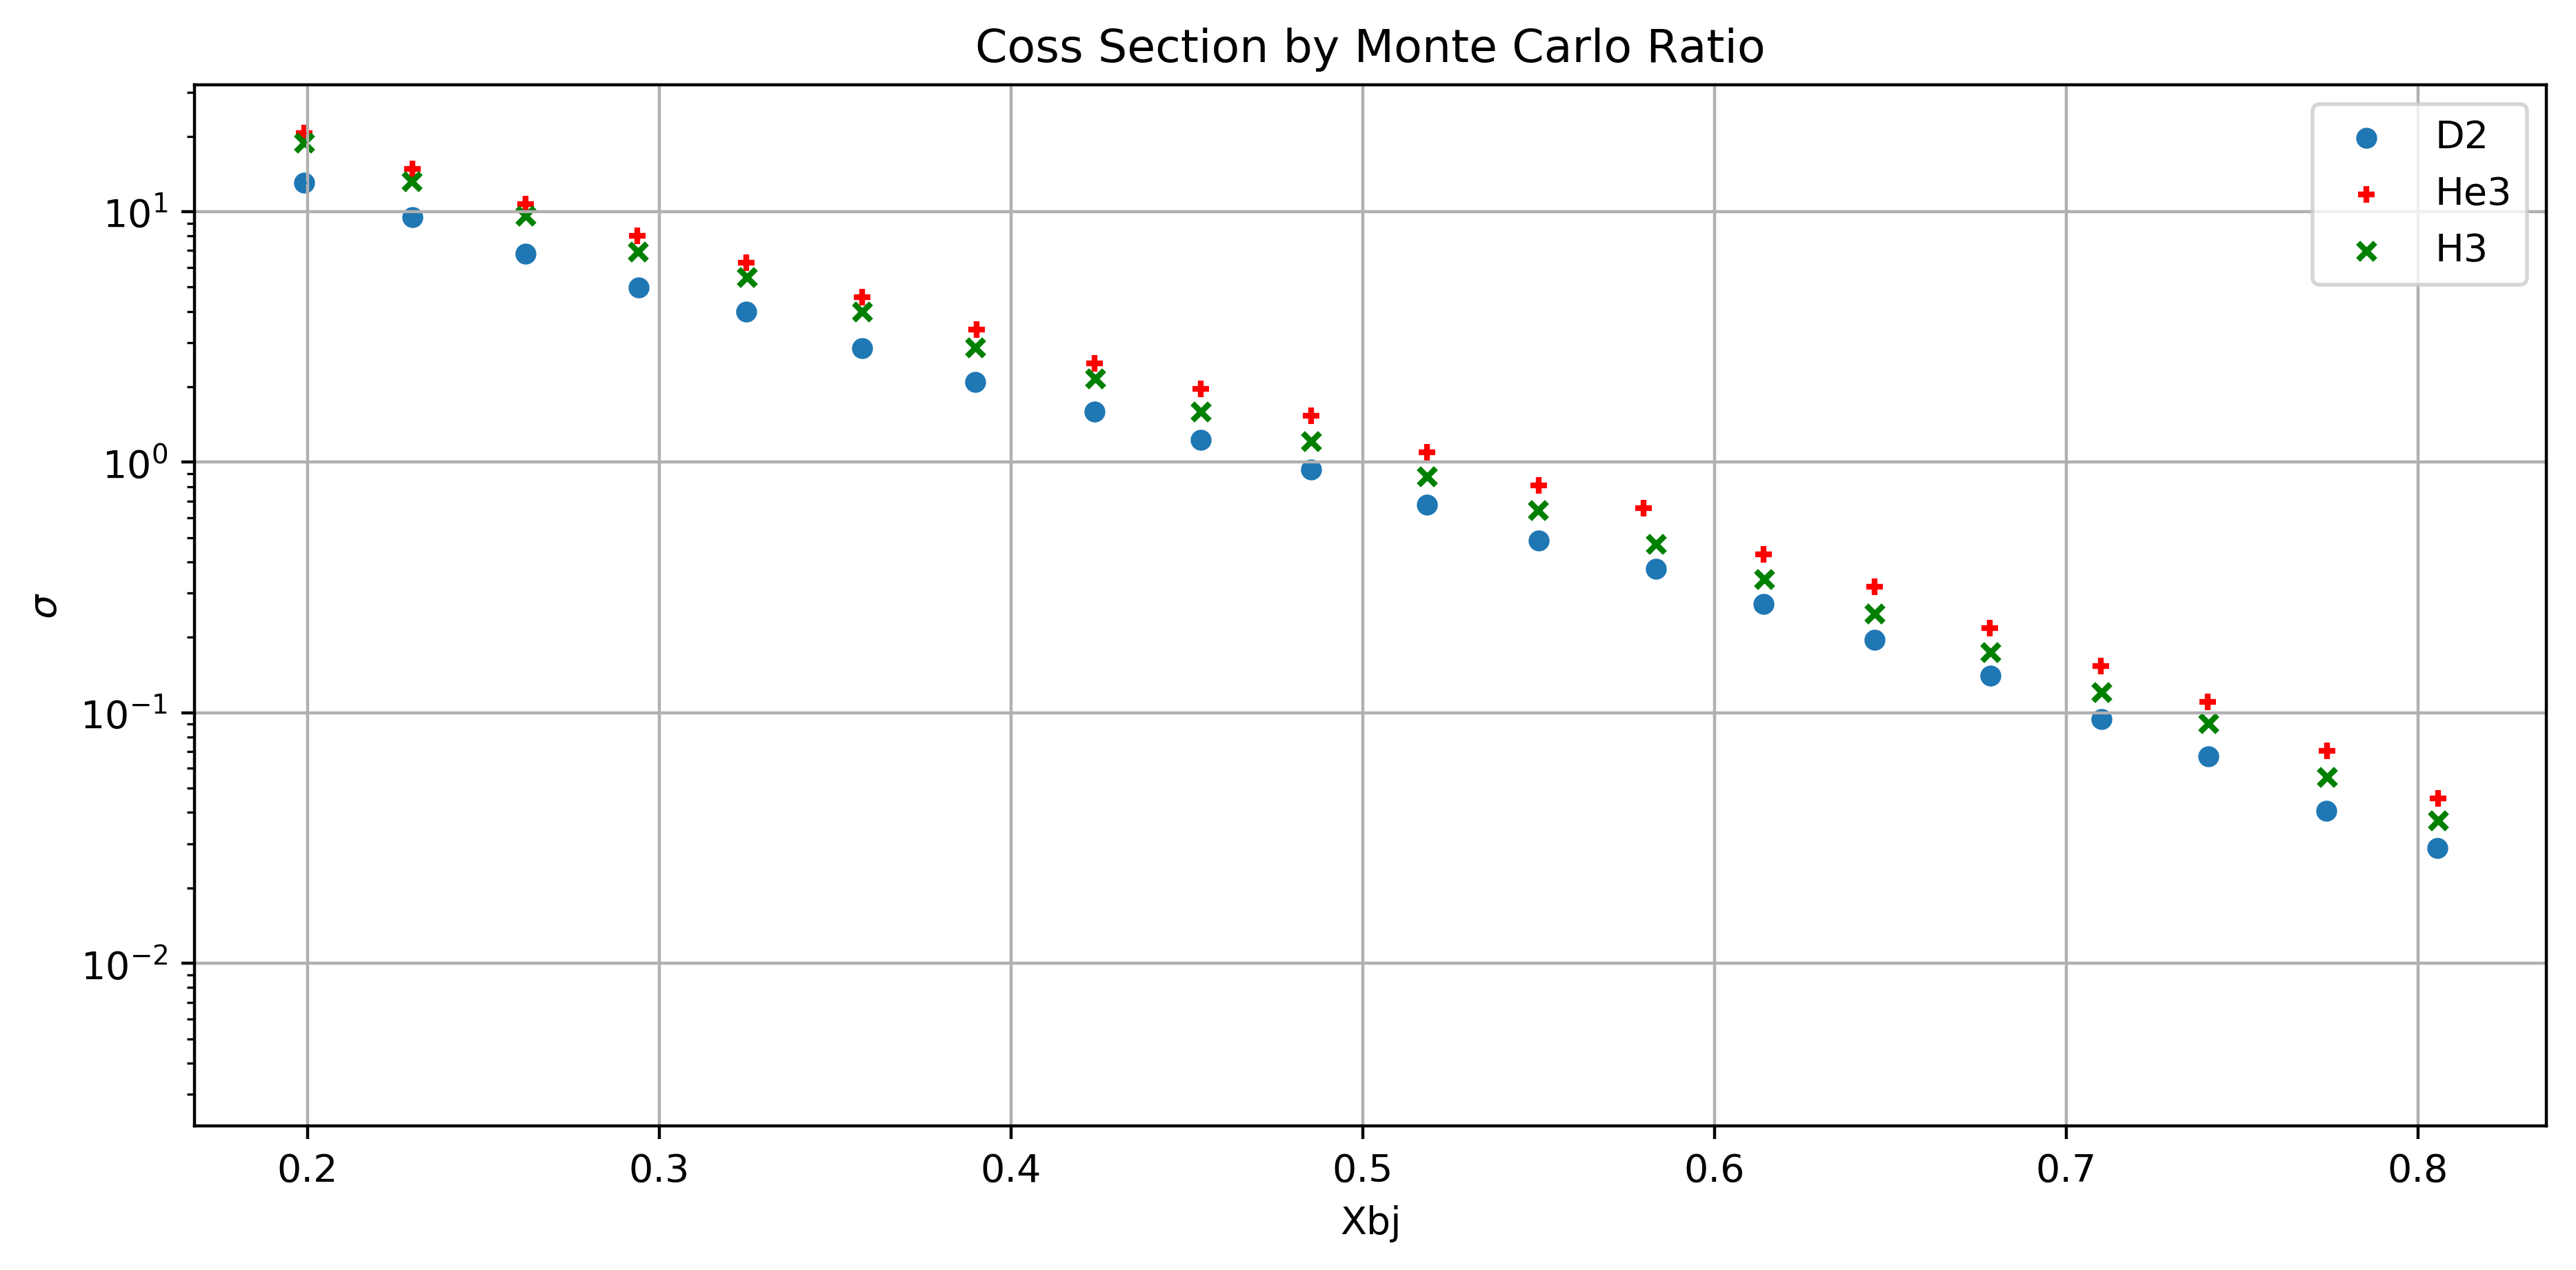

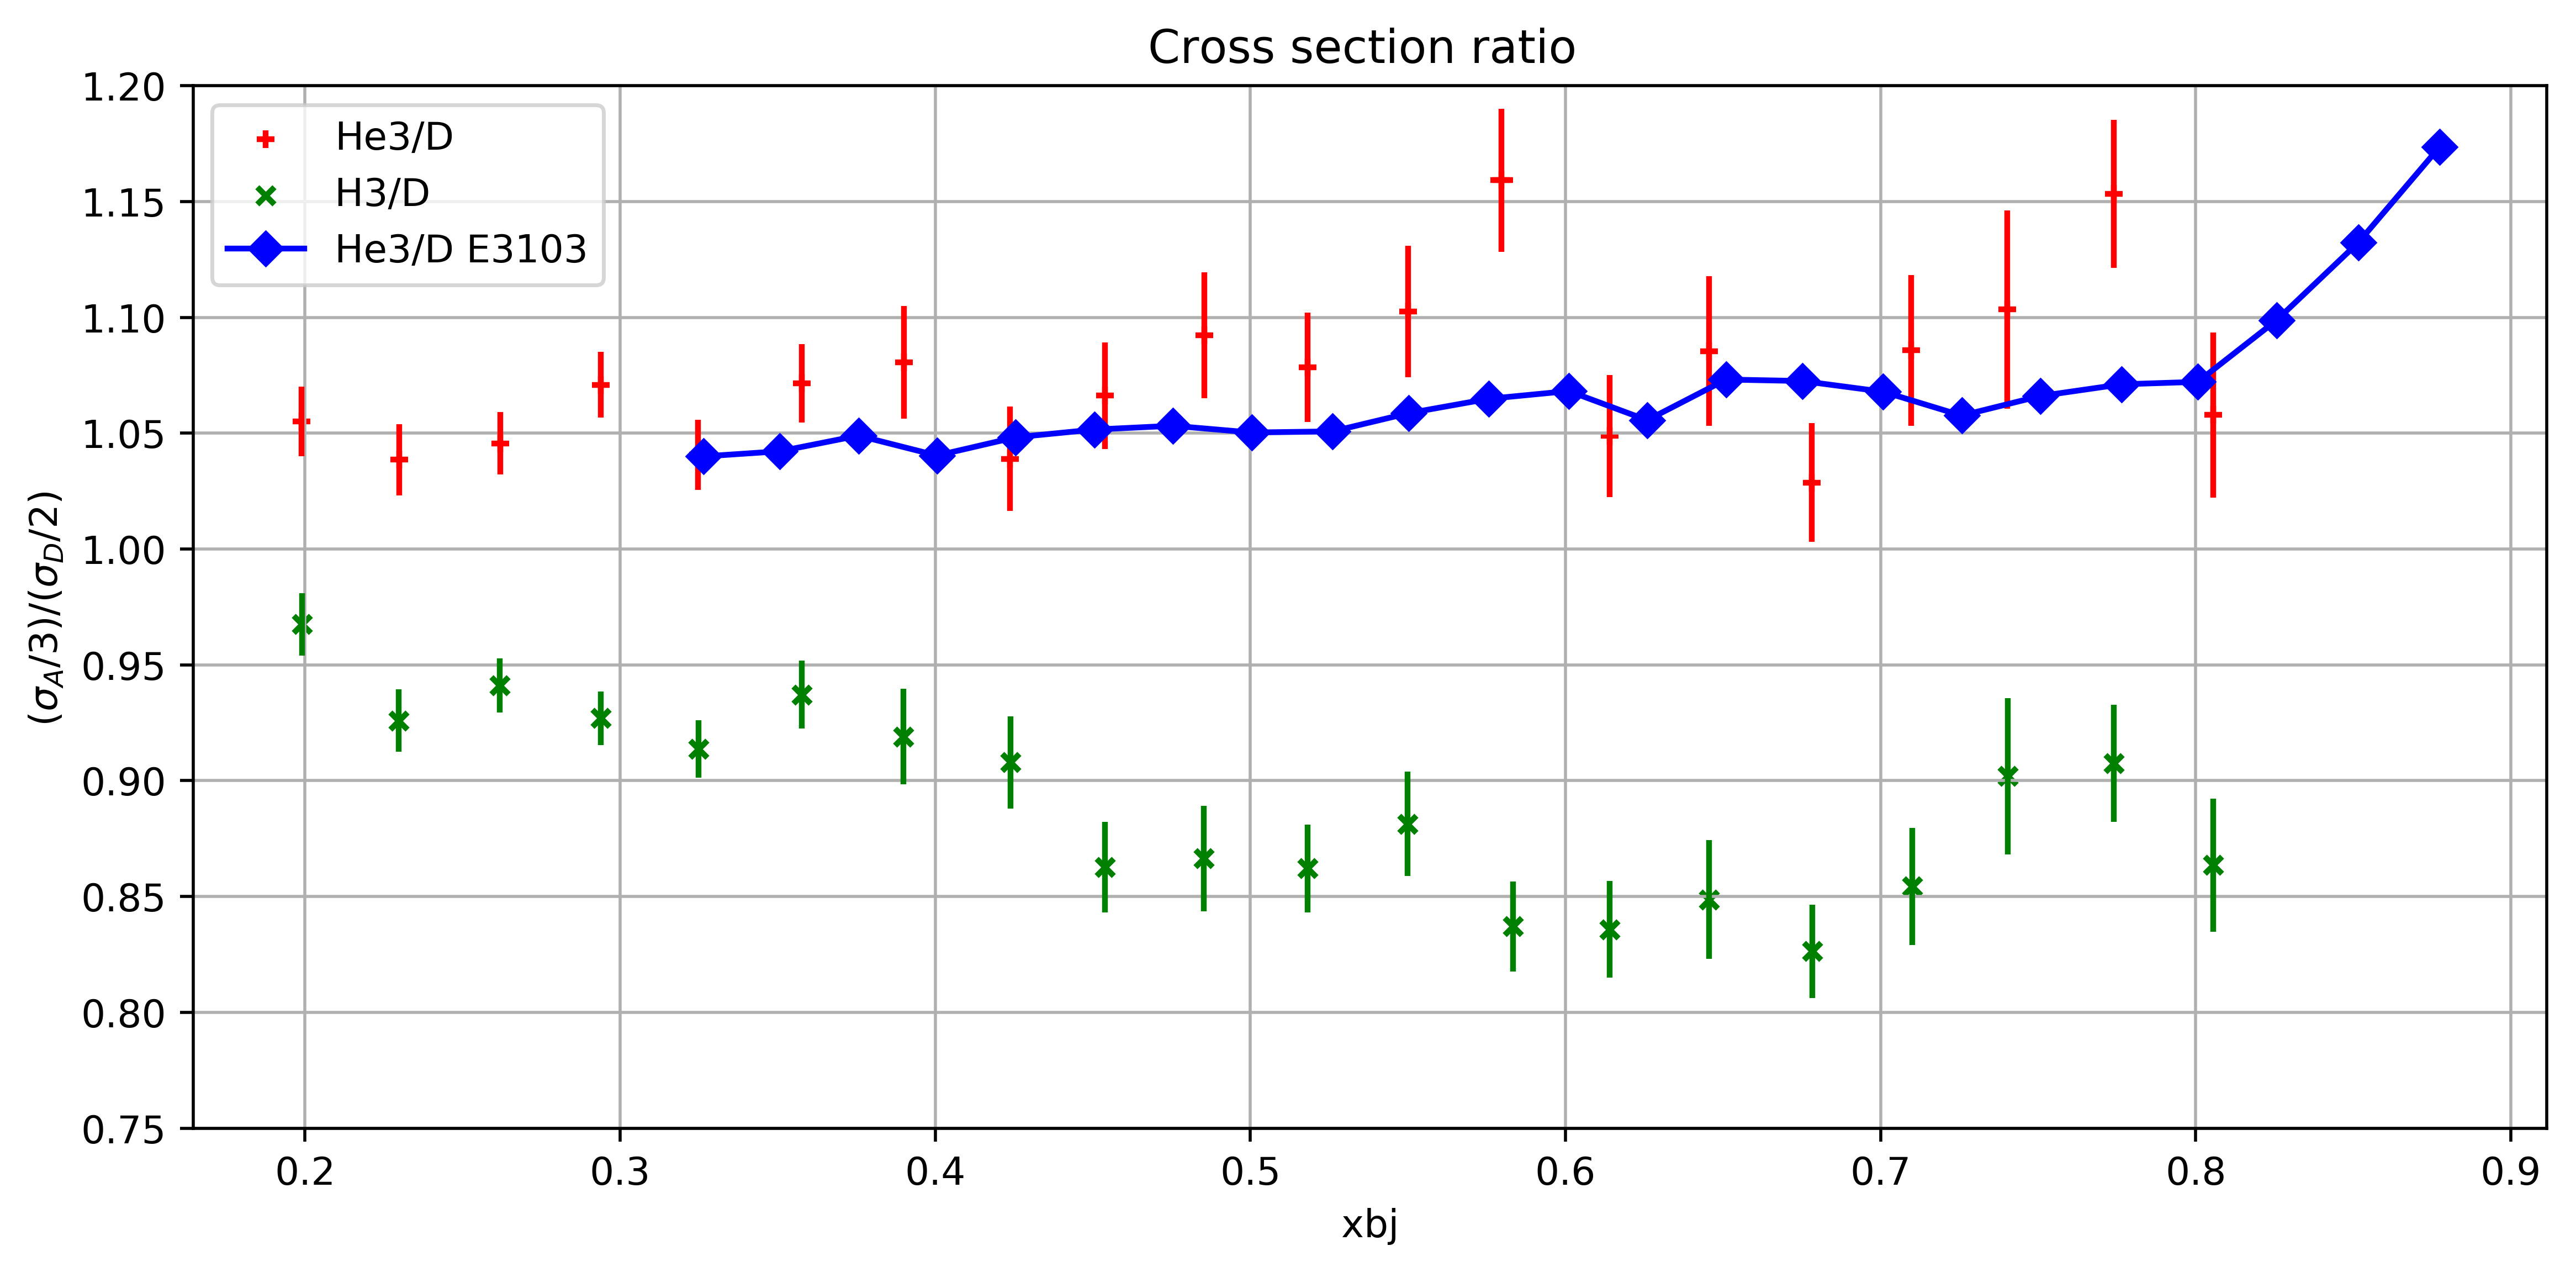

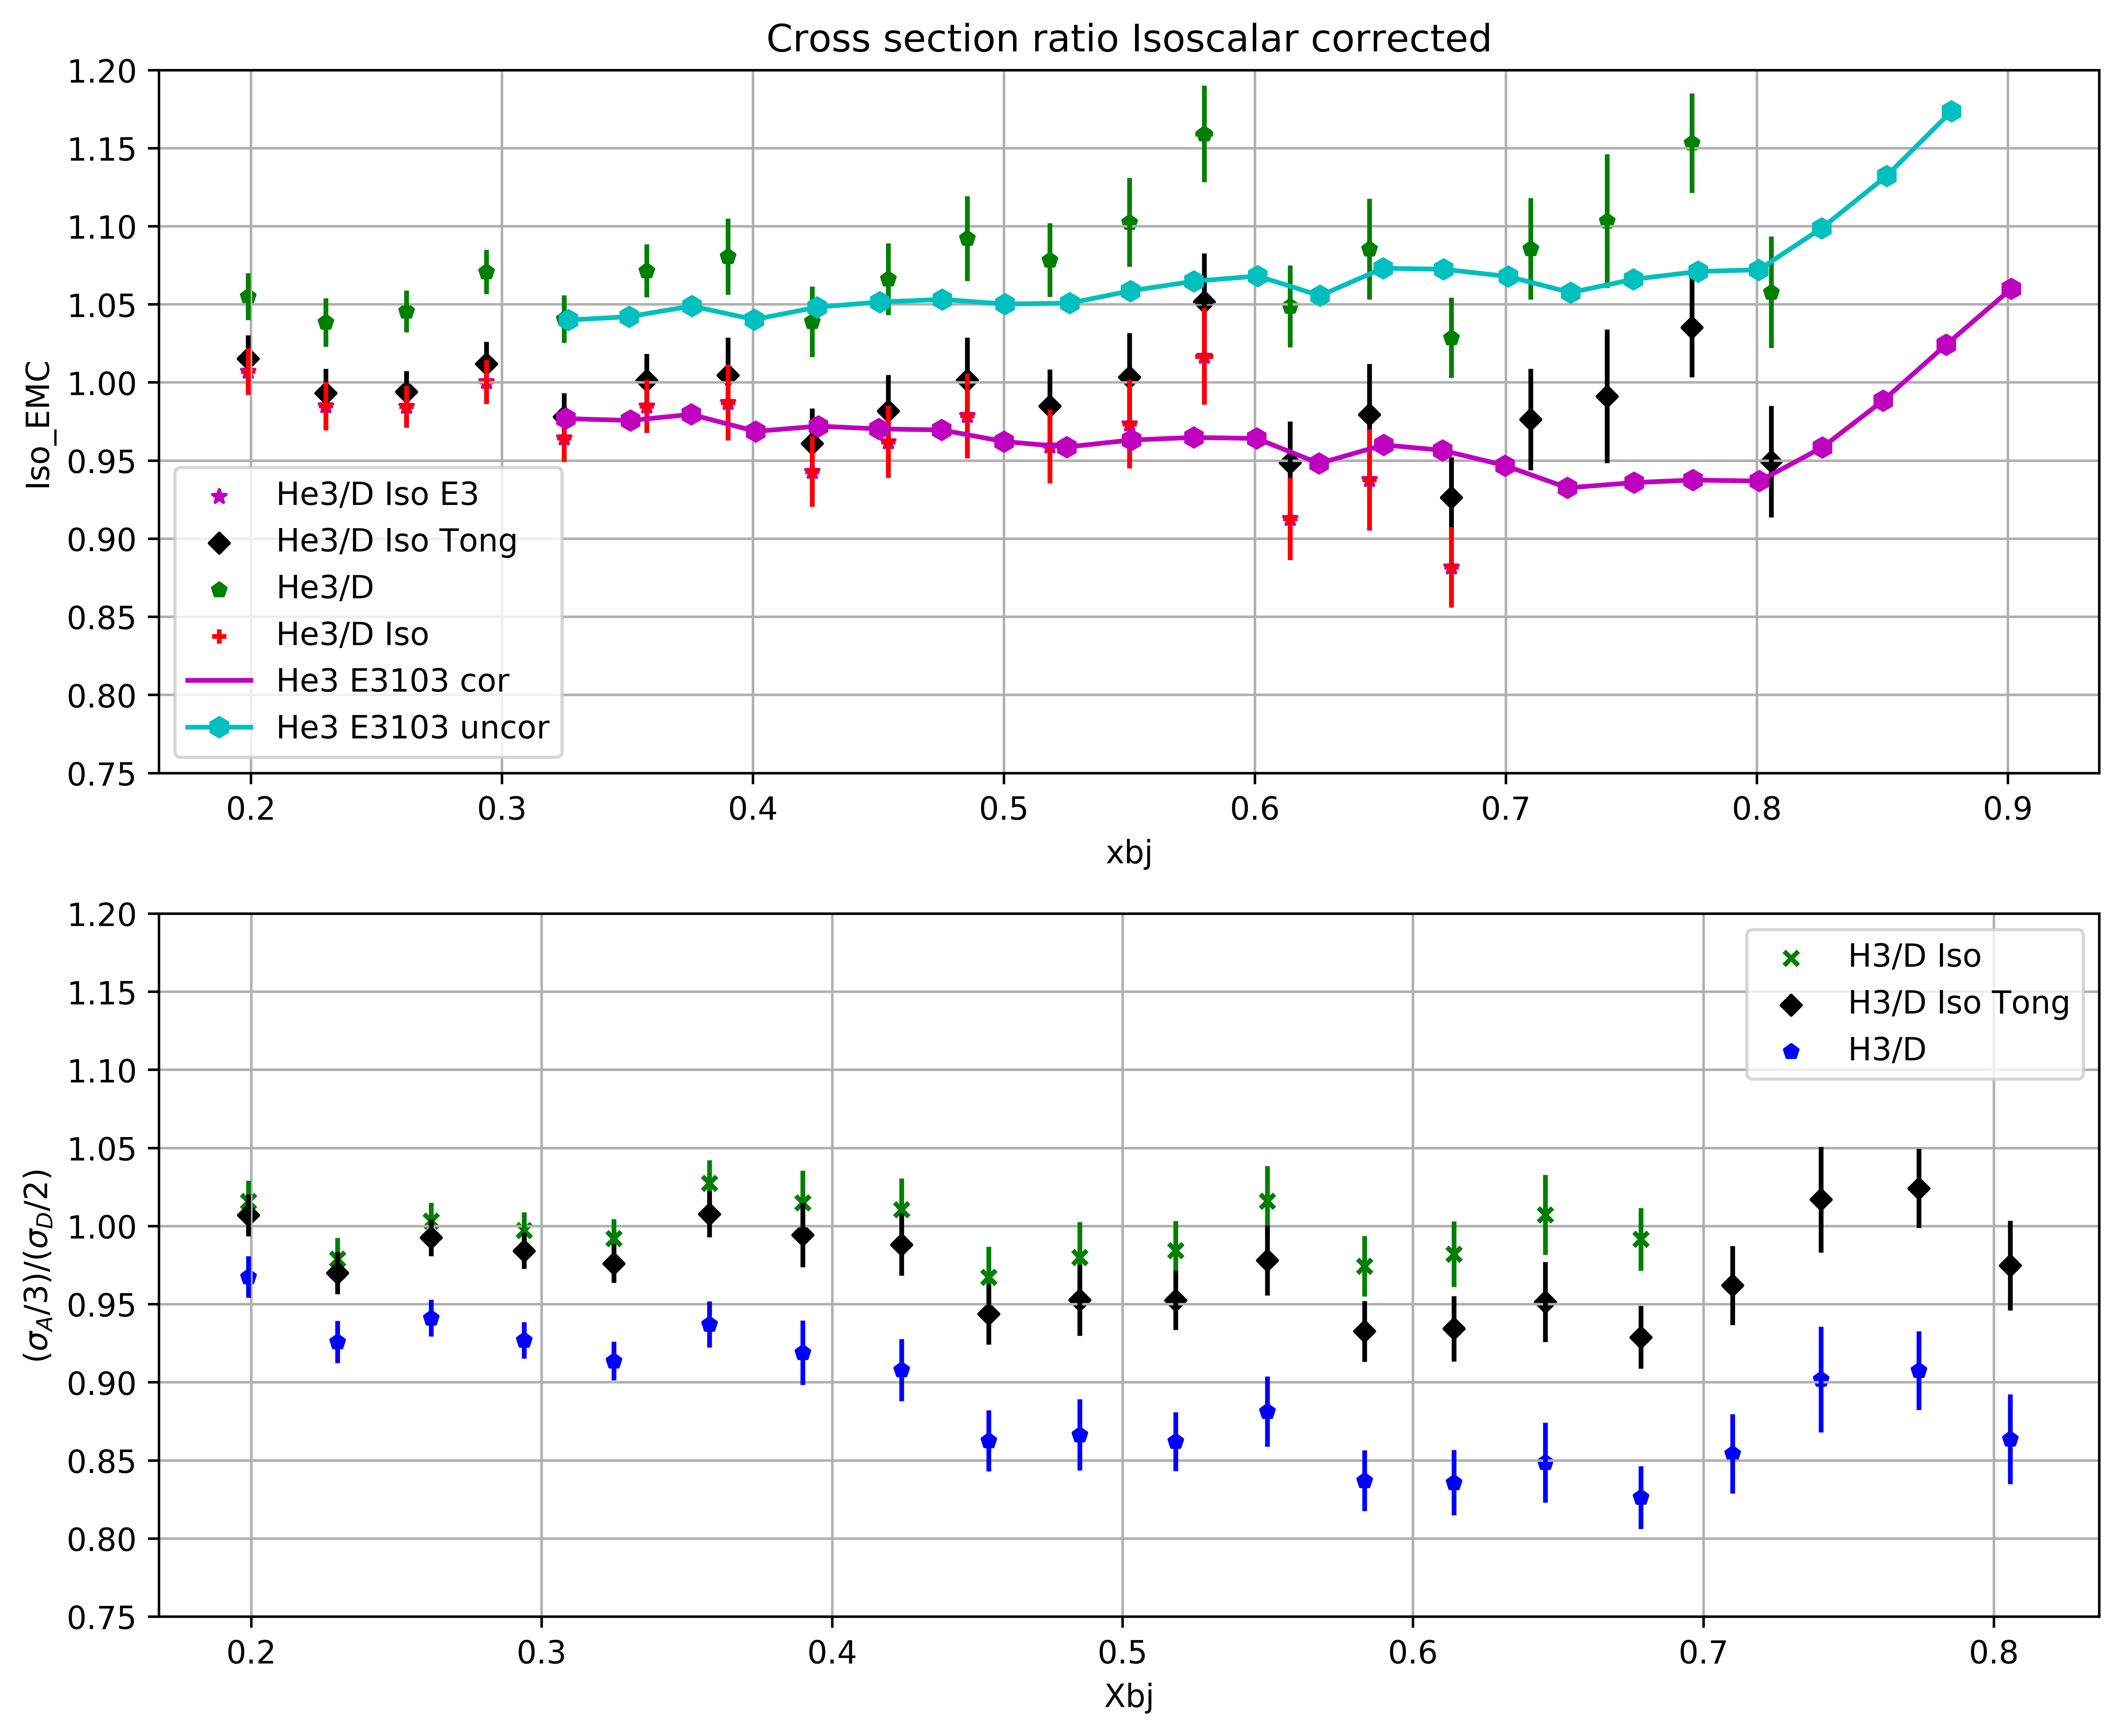

In [123]:
D2_ratios={}
He3_ratios={}
H3_ratios={}

bins =25
D2_ratios= all_tgt("D2",bins)
D2_full   = together("D2",D2_ratios,bins)

He3_ratios= all_tgt("He3",bins)
He3_full   = together("He3",He3_ratios,bins)

H3_ratios= all_tgt("H3",bins)
H3_full   = together("H3",H3_ratios,bins)


all_plots([D2_full,He3_full,H3_full],bins)
EMC(D2_full,He3_full,H3_full,bins)

ISO_EMC_both(D2_full,He3_full,H3_full,bins)

#He3_ratios = all_tgt("D2",25)
#He3_full   = together("D2",D2_ratios)
#H3_ratios = all_tgt("D2",25)
#H3_full   = together("D2",D2_ratios)


In [148]:
Fn_Fp= pd.read_csv("/home/jbane/Downloads/Fn_Fp.csv")
Fn_Fp

,xbj,<Q2>,Fn/Fp,Error,Total_Error
0,0.003,0.6,0.990,0.016,0.026
1,0.007,1.4,0.971,0.008,0.011
2,0.015,2.6,0.959,0.007,0.006
3,0.030,4.2,0.927,0.006,0.005
4,0.050,5.9,0.915,0.007,0.005
5,0.080,7.7,0.874,0.006,0.004
6,0.125,10.0,0.825,0.006,0.004
7,0.175,12.3,0.774,0.008,0.005
8,0.250,15.2,0.700,0.007,0.007
9,0.350,20.2,0.588,0.011,0.009
